## Stappenplan:
1. Data transformation
- Pivot; clean; remaining features:
      ['Datum', 'Binnengekomen bij Provider', 'Doorgeleid naar keuzemenu',
       'Door beller opgehangen in menu', 'Automatisch behandeld in menu',
       'Doorverbindingen_totaal',  'Wachtrij_totaal', 'Wachtrij_opgehangen_totaal',
       'Geholpen_totaal', 'Gemiddelde_wachttijd_totaal', & per cat:
       'Doorverbindingen_CAT', 
       'Wachtrij_CAT',
       'Wachtrij_opgehangen_CAT',
       'Geholpen_CAT', 
       'Gemiddelde_wachttijd_CAT']

2. Data analysis
- Moving average of calls/waiting time per category

- Calculating/defining capacity

- Is wachttijd consistent over time? Is nr of calls consistent over time? CHECK

- Is wachttijd correlated with complexity score?

- Similarity between categories

- Effect of the deadlines on calls?

- DTW, hierarchical clustering

2. Data enrichment
- Calender events/holidays/tax deadlines
- Weather

In [1]:
pip install workalendar

Note: you may need to restart the kernel to use updated packages.


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime
import time
import seaborn as sns
from cycler import cycler
from workalendar.europe import Netherlands
import json
from datetime import date, timedelta
from datetime import datetime 
import calendar

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

line_cycler   = (cycler(color=["#E69F00", "#56B4E9", "#009E73", "#0072B2", "#D55E00", "#CC79A7", "#F0E442"]) +
                 cycler(linestyle=["-", "--", "-.", ":", "-", "--", "-."]))

## 1. Data transformation

### Data inladen; kolom 'Datum' in data format zetten

In [3]:
data = pd.read_csv('belastingtelefoon_odt003 (3).csv', sep = ';', decimal = ",") # douane eruit

In [4]:
data['Datum'] = pd.to_datetime(data['Datum'], format =  "%d/%m/%Y")

### Kolommen hernoemen; null-waardes vervangen door 0

In [5]:
data = data.fillna(0) 

In [6]:
data.columns = ['Datum', 'Binnengekomen bij Provider', 'Doorgeleid naar keuzemenu',
       'Door beller opgehangen in menu', 'Automatisch behandeld in menu',
       'Thema', 'Doorverbindingen', 'Wachtrij',
       'Wachtrij_opgehangen', 'Geholpen',
       'Gemiddelde_wachttijd','','']
data=data[['Datum', 'Binnengekomen bij Provider', 'Doorgeleid naar keuzemenu',
       'Door beller opgehangen in menu', 'Automatisch behandeld in menu',
       'Thema', 'Doorverbindingen', 'Wachtrij',
       'Wachtrij_opgehangen', 'Geholpen',
       'Gemiddelde_wachttijd']]

In [7]:
df_dagelijkse_totaal = data[data['Thema'] == 'TOTAAL'][['Datum', 'Binnengekomen bij Provider', 'Doorgeleid naar keuzemenu',
       'Door beller opgehangen in menu', 'Automatisch behandeld in menu']]

### Pivot de thema kolommen en join deze df met de totals dataframe

In [8]:
df_dagelijkse_themas = data.pivot(index='Datum', columns='Thema', values=['Doorverbindingen', 'Wachtrij',
       'Wachtrij_opgehangen', 'Geholpen',
       'Gemiddelde_wachttijd'])

In [9]:
df_totaal = df_dagelijkse_totaal.join(df_dagelijkse_themas, on = 'Datum', how = 'inner')

In [10]:
df_totaal.columns

Index([                                  'Datum',
                    'Binnengekomen bij Provider',
                     'Doorgeleid naar keuzemenu',
                'Door beller opgehangen in menu',
                 'Automatisch behandeld in menu',
                    ('Doorverbindingen', 'AUTO'),
              ('Doorverbindingen', 'BUITENLAND'),
                  ('Doorverbindingen', 'DOUANE'),
           ('Doorverbindingen', 'INTERMEDIAIRS'),
           ('Doorverbindingen', 'ONDERNEMINGEN'),
               ('Doorverbindingen', 'ONTBREEKT'),
                  ('Doorverbindingen', 'OVERIG'),
           ('Doorverbindingen', 'PARTICULIEREN'),
               ('Doorverbindingen', 'TOESLAGEN'),
                  ('Doorverbindingen', 'TOTAAL'),
                            ('Wachtrij', 'AUTO'),
                      ('Wachtrij', 'BUITENLAND'),
                          ('Wachtrij', 'DOUANE'),
                   ('Wachtrij', 'INTERMEDIAIRS'),
                   ('Wachtrij', 'ONDERNEMINGEN'),


### Trek de douane kolommen af van het totaal (aangezien douane enkel een thema was tot februari 2020). Ga vervolgens verder met de resterende kolommen. 

In [11]:
df_totaal = df_totaal.fillna(0)
df_totaal['Binnengekomen bij Provider'] = df_totaal['Binnengekomen bij Provider'] - df_totaal[('Doorverbindingen', 'DOUANE')]
df_totaal['Doorgeleid naar keuzemenu'] = df_totaal['Doorgeleid naar keuzemenu'] - df_totaal[('Doorverbindingen', 'DOUANE')]
df_totaal[('Doorverbindingen', 'TOTAAL')] = df_totaal[('Doorverbindingen', 'TOTAAL')] - df_totaal[('Doorverbindingen', 'DOUANE')]
df_totaal[('Wachtrij', 'TOTAAL')] = df_totaal[('Wachtrij', 'TOTAAL')] - df_totaal[('Wachtrij', 'DOUANE')]
df_totaal[('Wachtrij_opgehangen', 'TOTAAL')] = df_totaal[('Wachtrij_opgehangen', 'TOTAAL')] - df_totaal[('Wachtrij_opgehangen', 'DOUANE')]
df_totaal[('Geholpen', 'TOTAAL')] = df_totaal[('Geholpen', 'TOTAAL')] - df_totaal[('Geholpen', 'DOUANE')]

### Trek de ontbrekende kolommen af van het totaal (aangezien we geen informatie hebben over de beller, kunnen we hier niets mee). Dit zijn 13 rijen. 

In [12]:
df_totaal['Wachtrij', 'ONTBREEKT'][df_totaal[('Wachtrij', 'ONTBREEKT')].notna()]

0       0.0
9       0.0
18      0.0
27      0.0
36      0.0
       ... 
7664    0.0
7672    0.0
7680    0.0
7688    0.0
7696    0.0
Name: (Wachtrij, ONTBREEKT), Length: 928, dtype: float64

In [13]:
df_totaal['Binnengekomen bij Provider'] = df_totaal['Binnengekomen bij Provider'] - df_totaal[('Doorverbindingen', 'ONTBREEKT')]
df_totaal['Doorgeleid naar keuzemenu'] = df_totaal['Doorgeleid naar keuzemenu'] - df_totaal[('Doorverbindingen', 'ONTBREEKT')]
df_totaal[('Doorverbindingen', 'TOTAAL')] = df_totaal[('Doorverbindingen', 'TOTAAL')] - df_totaal[('Doorverbindingen', 'ONTBREEKT')]
df_totaal[('Wachtrij', 'TOTAAL')] = df_totaal[('Wachtrij', 'TOTAAL')] - df_totaal[('Wachtrij', 'ONTBREEKT')]
df_totaal[('Wachtrij_opgehangen', 'TOTAAL')] = df_totaal[('Wachtrij_opgehangen', 'TOTAAL')] - df_totaal[('Wachtrij_opgehangen', 'ONTBREEKT')]
df_totaal[('Geholpen', 'TOTAAL')] = df_totaal[('Geholpen', 'TOTAAL')] - df_totaal[('Geholpen', 'ONTBREEKT')]

### Op 2022-09-14 zijn er geen oproepen geregistreerd. Het is mij onbekend of dit komt door een interne storing bij de belastingdienst, maar het lijkt erop dat die dag wel oproepen zijn binnengekomen, doorgeleid en afgewerkt, aangezien online geen informatie te vinden valt. Logischerwijs moet deze datum uit de data worden verwijderd. 

In [14]:
df_totaal = df_totaal.drop(axis=0, index = df_totaal[df_totaal['Datum'] == '2022-09-14'].index)

In [15]:

df_totaal = df_totaal[['Datum',
                    'Binnengekomen bij Provider',
                     'Doorgeleid naar keuzemenu',
                'Door beller opgehangen in menu',
                 'Automatisch behandeld in menu',
                    ('Doorverbindingen', 'AUTO'),
              ('Doorverbindingen', 'BUITENLAND'),
                  ('Doorverbindingen', 'DOUANE'),
           ('Doorverbindingen', 'INTERMEDIAIRS'),
           ('Doorverbindingen', 'ONDERNEMINGEN'),
               ('Doorverbindingen', 'ONTBREEKT'),
                  ('Doorverbindingen', 'OVERIG'),
           ('Doorverbindingen', 'PARTICULIEREN'),
               ('Doorverbindingen', 'TOESLAGEN'),
                  ('Doorverbindingen', 'TOTAAL'),
                            ('Wachtrij', 'AUTO'),
                      ('Wachtrij', 'BUITENLAND'),
                   ('Wachtrij', 'INTERMEDIAIRS'),
                   ('Wachtrij', 'ONDERNEMINGEN'),
                       ('Wachtrij', 'ONTBREEKT'),
                          ('Wachtrij', 'OVERIG'),
                   ('Wachtrij', 'PARTICULIEREN'),
                       ('Wachtrij', 'TOESLAGEN'),
                          ('Wachtrij', 'TOTAAL'),
                 ('Wachtrij_opgehangen', 'AUTO'),
           ('Wachtrij_opgehangen', 'BUITENLAND'),
        ('Wachtrij_opgehangen', 'INTERMEDIAIRS'),
        ('Wachtrij_opgehangen', 'ONDERNEMINGEN'),
            ('Wachtrij_opgehangen', 'ONTBREEKT'),
               ('Wachtrij_opgehangen', 'OVERIG'),
        ('Wachtrij_opgehangen', 'PARTICULIEREN'),
            ('Wachtrij_opgehangen', 'TOESLAGEN'),
               ('Wachtrij_opgehangen', 'TOTAAL'),
                            ('Geholpen', 'AUTO'),
                      ('Geholpen', 'BUITENLAND'),
                   ('Geholpen', 'INTERMEDIAIRS'),
                   ('Geholpen', 'ONDERNEMINGEN'),
                       ('Geholpen', 'ONTBREEKT'),
                          ('Geholpen', 'OVERIG'),
                   ('Geholpen', 'PARTICULIEREN'),
                       ('Geholpen', 'TOESLAGEN'),
                          ('Geholpen', 'TOTAAL'),
                ('Gemiddelde_wachttijd', 'AUTO'),
          ('Gemiddelde_wachttijd', 'BUITENLAND'),
       ('Gemiddelde_wachttijd', 'INTERMEDIAIRS'),
       ('Gemiddelde_wachttijd', 'ONDERNEMINGEN'),
           ('Gemiddelde_wachttijd', 'ONTBREEKT'),
              ('Gemiddelde_wachttijd', 'OVERIG'),
       ('Gemiddelde_wachttijd', 'PARTICULIEREN'),
           ('Gemiddelde_wachttijd', 'TOESLAGEN'),
              ('Gemiddelde_wachttijd', 'TOTAAL')]]

# Maand en jaar kolommen toevoegen
df_totaal['Maand'] = df_totaal['Datum'].dt.strftime('%b')
df_totaal['Jaar'] = df_totaal['Datum'].dt.strftime('%Y')

# Complexiteitsscores toevoegen
df_totaal['ComplexityScore_ondernemingen'] = 1
df_totaal['ComplexityScore_particulieren'] = 2
df_totaal['ComplexityScore_buitenland'] = 3
df_totaal['ComplexityScore_overig'] = 4
df_totaal['ComplexityScore_intermediairs'] = 5
df_totaal['ComplexityScore_toeslagen'] = 6
df_totaal['ComplexityScore_auto'] = 7

df_totaal['DagvdWeek'] = df_totaal['Datum'].dt.dayofweek
df_totaal['Maand'] = df_totaal['Datum'].dt.month
df_totaal['Dag'] = df_totaal['Datum'].dt.day
df_totaal['WeekNr'] = df_totaal['Datum'].dt.isocalendar().week

/opt/conda/lib/python3.9/site-packages/pandas/core/common.py:241: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  result = np.asarray(values, dtype=dtype)


In [16]:
df_totaal = df_totaal.reset_index(drop = True)

### Aparte dataframe aanmaken voor elk thema
Particulieren, toeslagen, ondernemingen, buitenland, auto, intermediairs, overig

In [17]:
# DF Particulieren
df_particulieren = df_totaal[[ 'Datum', 'Maand', 'Jaar',
                    'DagvdWeek', 'Dag', 'WeekNr', 
                    'Binnengekomen bij Provider',
                    'Doorgeleid naar keuzemenu',
                    'Door beller opgehangen in menu',
                    'Automatisch behandeld in menu',
                    'ComplexityScore_particulieren',
                    ('Doorverbindingen', 'PARTICULIEREN'),
                    ('Doorverbindingen', 'TOTAAL'),
                    ('Wachtrij', 'PARTICULIEREN'),
                    ('Wachtrij', 'TOTAAL'),
                    ('Wachtrij_opgehangen', 'PARTICULIEREN'),
                    ('Wachtrij_opgehangen', 'TOTAAL'),
                    ('Geholpen', 'PARTICULIEREN'),
                    ('Geholpen', 'TOTAAL'),
                    ('Gemiddelde_wachttijd', 'PARTICULIEREN'),
                    ('Gemiddelde_wachttijd', 'TOTAAL')]]

df_particulieren.columns = [ 'Datum', 'Maand', 'Jaar',
                    'DagvdWeek', 'Dag', 'WeekNr', 
                    'Binnengekomen bij Provider',
                    'Doorgeleid naar keuzemenu',
                    'Door beller opgehangen in menu',
                    'Automatisch behandeld in menu',
                    'ComplexityScore_particulieren',
                    ('Doorverbindingen_particulieren'),
                    ('Doorverbindingen_totaal'),
                    ('Wachtrij_particulieren'),
                    ('Wachtrij_totaal'),
                    ('Wachtrij_opgehangen_particulieren'),
                    ('Wachtrij_opgehangen_totaal'),
                    ('Geholpen_particulieren'),
                    ('Geholpen_totaal'),
                    ('Gemiddelde_wachttijd_particulieren'),
                    ('Gemiddelde_wachttijd_totaal')]

/opt/conda/lib/python3.9/site-packages/pandas/core/common.py:241: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  result = np.asarray(values, dtype=dtype)


In [18]:
# DF toeslagen
df_toeslagen = df_totaal[[ 'Datum', 'Maand', 'Jaar',
                    'DagvdWeek', 'Dag', 'WeekNr', 
                    'Binnengekomen bij Provider',
                    'Doorgeleid naar keuzemenu',
                    'Door beller opgehangen in menu',
                    'Automatisch behandeld in menu',
                    'ComplexityScore_toeslagen',
                    ('Doorverbindingen', 'TOESLAGEN'),
                    ('Doorverbindingen', 'TOTAAL'),
                    ('Wachtrij', 'TOESLAGEN'),
                    ('Wachtrij', 'TOTAAL'),
                    ('Wachtrij_opgehangen', 'TOESLAGEN'),
                    ('Wachtrij_opgehangen', 'TOTAAL'),
                    ('Geholpen', 'TOESLAGEN'),
                    ('Geholpen', 'TOTAAL'),
                    ('Gemiddelde_wachttijd', 'TOESLAGEN'),
                    ('Gemiddelde_wachttijd', 'TOTAAL')]]

df_toeslagen.columns =  ['Datum', 'Maand', 'Jaar',
                      'DagvdWeek', 'Dag', 'WeekNr', 
                      'Binnengekomen bij Provider',
                      'Doorgeleid naar keuzemenu',
                      'Door beller opgehangen in menu',
                      'Automatisch behandeld in menu',
                      'ComplexityScore_ondernemingen',
                      'Doorverbindingen_toeslagen',
                      'Doorverbindingen_totaal',
                      'Wachtrij_toeslagen',
                      'Wachtrij_totaal',
                      'Wachtrij_opgehangen_toeslagen',
                      'Wachtrij_opgehangen_totaal',
                      'Geholpen_toeslagen',
                      'Geholpen_totaal',
                      'Gemiddelde_wachttijd_toeslagen',
                      'Gemiddelde_wachttijd_totaal']

/opt/conda/lib/python3.9/site-packages/pandas/core/common.py:241: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  result = np.asarray(values, dtype=dtype)


In [19]:
# DF ondernemingen
df_ondernemingen = df_totaal[[ 'Datum', 'Maand', 'Jaar',
                    'DagvdWeek', 'Dag', 'WeekNr', 
                    'Binnengekomen bij Provider',
                    'Doorgeleid naar keuzemenu',
                    'Door beller opgehangen in menu',
                    'Automatisch behandeld in menu',
                    'ComplexityScore_ondernemingen',
                    ('Doorverbindingen', 'ONDERNEMINGEN'),
                    ('Doorverbindingen', 'TOTAAL'),
                    ('Wachtrij', 'ONDERNEMINGEN'),
                    ('Wachtrij', 'TOTAAL'),
                    ('Wachtrij_opgehangen', 'ONDERNEMINGEN'),
                    ('Wachtrij_opgehangen', 'TOTAAL'),
                    ('Geholpen', 'ONDERNEMINGEN'),
                    ('Geholpen', 'TOTAAL'),
                    ('Gemiddelde_wachttijd', 'ONDERNEMINGEN'),
                    ('Gemiddelde_wachttijd', 'TOTAAL')]]

df_ondernemingen.columns =  ['Datum', 'Maand', 'Jaar',
                      'DagvdWeek', 'Dag', 'WeekNr', 
                      'Binnengekomen bij Provider',
                      'Doorgeleid naar keuzemenu',
                      'Door beller opgehangen in menu',
                      'Automatisch behandeld in menu',
                      'ComplexityScore_ondernemingen',
                      'Doorverbindingen_ondernemingen',
                      'Doorverbindingen_totaal',
                      'Wachtrij_ondernemingen',
                      'Wachtrij_totaal',
                      'Wachtrij_opgehangen_ondernemingen',
                      'Wachtrij_opgehangen_totaal',
                      'Geholpen_ondernemingen',
                      'Geholpen_totaal',
                      'Gemiddelde_wachttijd_ondernemingen',
                      'Gemiddelde_wachttijd_totaal']

/opt/conda/lib/python3.9/site-packages/pandas/core/common.py:241: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  result = np.asarray(values, dtype=dtype)


In [20]:
# DF buitenland
df_buitenland = df_totaal[[ 'Datum', 'Maand', 'Jaar',
                    'DagvdWeek', 'Dag', 'WeekNr', 
                    'Binnengekomen bij Provider',
                    'Doorgeleid naar keuzemenu',
                    'Door beller opgehangen in menu',
                    'Automatisch behandeld in menu',
                    'ComplexityScore_buitenland',
                    ('Doorverbindingen', 'BUITENLAND'),
                    ('Doorverbindingen', 'TOTAAL'),
                    ('Wachtrij', 'BUITENLAND'),
                    ('Wachtrij', 'TOTAAL'),
                    ('Wachtrij_opgehangen', 'BUITENLAND'),
                    ('Wachtrij_opgehangen', 'TOTAAL'),
                    ('Geholpen', 'BUITENLAND'),
                    ('Geholpen', 'TOTAAL'),
                    ('Gemiddelde_wachttijd', 'BUITENLAND'),
                    ('Gemiddelde_wachttijd', 'TOTAAL')]]

df_buitenland.columns =  ['Datum', 'Maand', 'Jaar',
                      'DagvdWeek', 'Dag', 'WeekNr', 
                      'Binnengekomen bij Provider',
                      'Doorgeleid naar keuzemenu',
                      'Door beller opgehangen in menu',
                      'Automatisch behandeld in menu',
                      'ComplexityScore_buitenland',
                      'Doorverbindingen_buitenland',
                      'Doorverbindingen_totaal',
                      'Wachtrij_buitenland',
                      'Wachtrij_totaal',
                      'Wachtrij_opgehangen_buitenland',
                      'Wachtrij_opgehangen_totaal',
                      'Geholpen_buitenland',
                      'Geholpen_totaal',
                      'Gemiddelde_wachttijd_buitenland',
                      'Gemiddelde_wachttijd_totaal']

/opt/conda/lib/python3.9/site-packages/pandas/core/common.py:241: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  result = np.asarray(values, dtype=dtype)


In [21]:
# DF auto
df_auto = df_totaal[[ 'Datum', 'Maand', 'Jaar',
                    'DagvdWeek', 'Dag', 'WeekNr', 
                    'Binnengekomen bij Provider',
                    'Doorgeleid naar keuzemenu',
                    'Door beller opgehangen in menu',
                    'Automatisch behandeld in menu',
                    'ComplexityScore_auto',
                    ('Doorverbindingen', 'AUTO'),
                    ('Doorverbindingen', 'TOTAAL'),
                    ('Wachtrij', 'AUTO'),
                    ('Wachtrij', 'TOTAAL'),
                    ('Wachtrij_opgehangen', 'AUTO'),
                    ('Wachtrij_opgehangen', 'TOTAAL'),
                    ('Geholpen', 'AUTO'),
                    ('Geholpen', 'TOTAAL'),
                    ('Gemiddelde_wachttijd', 'AUTO'),
                    ('Gemiddelde_wachttijd', 'TOTAAL')]]

df_auto.columns =  ['Datum', 'Maand', 'Jaar',
                      'DagvdWeek', 'Dag', 'WeekNr', 
                      'Binnengekomen bij Provider',
                      'Doorgeleid naar keuzemenu',
                      'Door beller opgehangen in menu',
                      'Automatisch behandeld in menu',
                      'ComplexityScore_auto',
                      'Doorverbindingen_auto',
                      'Doorverbindingen_totaal',
                      'Wachtrij_auto',
                      'Wachtrij_totaal',
                      'Wachtrij_opgehangen_auto',
                      'Wachtrij_opgehangen_totaal',
                      'Geholpen_auto',
                      'Geholpen_totaal',
                      'Gemiddelde_wachttijd_auto',
                      'Gemiddelde_wachttijd_totaal']

/opt/conda/lib/python3.9/site-packages/pandas/core/common.py:241: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  result = np.asarray(values, dtype=dtype)


In [22]:
# DF intermediairs
df_intermediairs = df_totaal[[ 'Datum', 'Maand', 'Jaar',
                    'DagvdWeek', 'Dag', 'WeekNr', 
                    'Binnengekomen bij Provider',
                    'Doorgeleid naar keuzemenu',
                    'Door beller opgehangen in menu',
                    'Automatisch behandeld in menu',
                    'ComplexityScore_intermediairs',
                    ('Doorverbindingen', 'INTERMEDIAIRS'),
                    ('Doorverbindingen', 'TOTAAL'),
                    ('Wachtrij', 'INTERMEDIAIRS'),
                    ('Wachtrij', 'TOTAAL'),
                    ('Wachtrij_opgehangen', 'INTERMEDIAIRS'),
                    ('Wachtrij_opgehangen', 'TOTAAL'),
                    ('Geholpen', 'INTERMEDIAIRS'),
                    ('Geholpen', 'TOTAAL'),
                    ('Gemiddelde_wachttijd', 'INTERMEDIAIRS'),
                    ('Gemiddelde_wachttijd', 'TOTAAL')]]

df_intermediairs.columns =  ['Datum', 'Maand', 'Jaar',
                      'DagvdWeek', 'Dag', 'WeekNr', 
                      'Binnengekomen bij Provider',
                      'Doorgeleid naar keuzemenu',
                      'Door beller opgehangen in menu',
                      'Automatisch behandeld in menu',
                      'ComplexityScore_intermediairs',
                      'Doorverbindingen_intermediairs',
                      'Doorverbindingen_totaal',
                      'Wachtrij_intermediairs',
                      'Wachtrij_totaal',
                      'Wachtrij_opgehangen_intermediairs',
                      'Wachtrij_opgehangen_totaal',
                      'Geholpen_intermediairs',
                      'Geholpen_totaal',
                      'Gemiddelde_wachttijd_intermediairs',
                      'Gemiddelde_wachttijd_totaal']

/opt/conda/lib/python3.9/site-packages/pandas/core/common.py:241: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  result = np.asarray(values, dtype=dtype)


In [23]:
# DF overig
df_overig = df_totaal[[ 'Datum', 'Maand', 'Jaar',
                    'DagvdWeek', 'Dag', 'WeekNr', 
                    'Binnengekomen bij Provider',
                    'Doorgeleid naar keuzemenu',
                    'Door beller opgehangen in menu',
                    'Automatisch behandeld in menu',
                    'ComplexityScore_overig',
                    ('Doorverbindingen', 'OVERIG'),
                    ('Doorverbindingen', 'TOTAAL'),
                    ('Wachtrij', 'OVERIG'),
                    ('Wachtrij', 'TOTAAL'),
                    ('Wachtrij_opgehangen', 'OVERIG'),
                    ('Wachtrij_opgehangen', 'TOTAAL'),
                    ('Geholpen', 'OVERIG'),
                    ('Geholpen', 'TOTAAL'),
                    ('Gemiddelde_wachttijd', 'OVERIG'),
                    ('Gemiddelde_wachttijd', 'TOTAAL')]]

df_overig.columns =  ['Datum', 'Maand', 'Jaar',
                      'DagvdWeek', 'Dag', 'WeekNr', 
                      'Binnengekomen bij Provider',
                      'Doorgeleid naar keuzemenu',
                      'Door beller opgehangen in menu',
                      'Automatisch behandeld in menu',
                      'ComplexityScore_overig',
                      'Doorverbindingen_overig',
                      'Doorverbindingen_totaal',
                      'Wachtrij_overig',
                      'Wachtrij_totaal',
                      'Wachtrij_opgehangen_overig',
                      'Wachtrij_opgehangen_totaal',
                      'Geholpen_overig',
                      'Geholpen_totaal',
                      'Gemiddelde_wachttijd_overig',
                      'Gemiddelde_wachttijd_totaal']

/opt/conda/lib/python3.9/site-packages/pandas/core/common.py:241: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  result = np.asarray(values, dtype=dtype)


## 2. Data analysis

### Trend van inkomende calls jaarlijks


#### Totaal

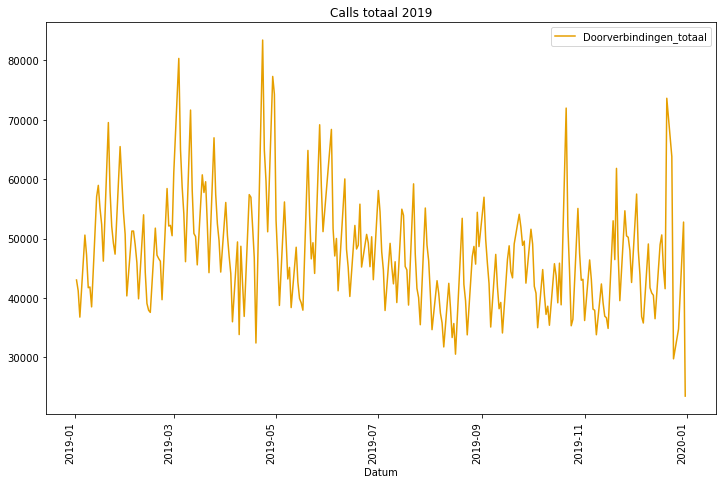

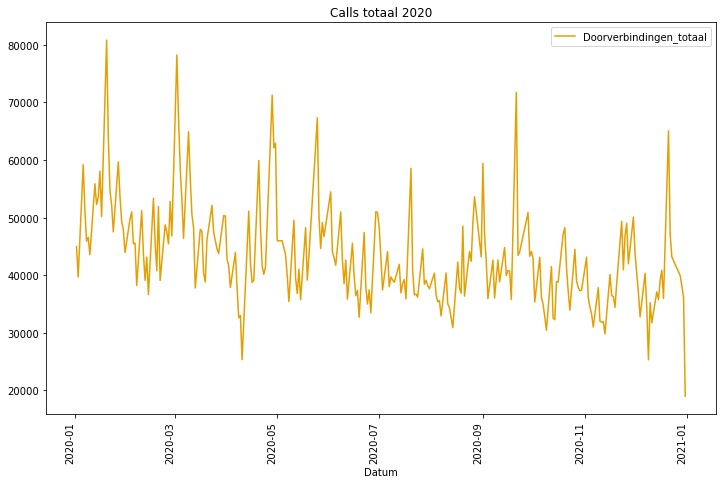

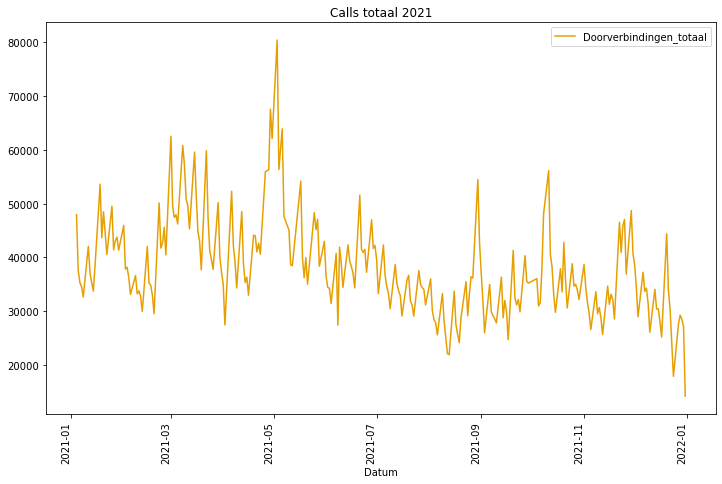

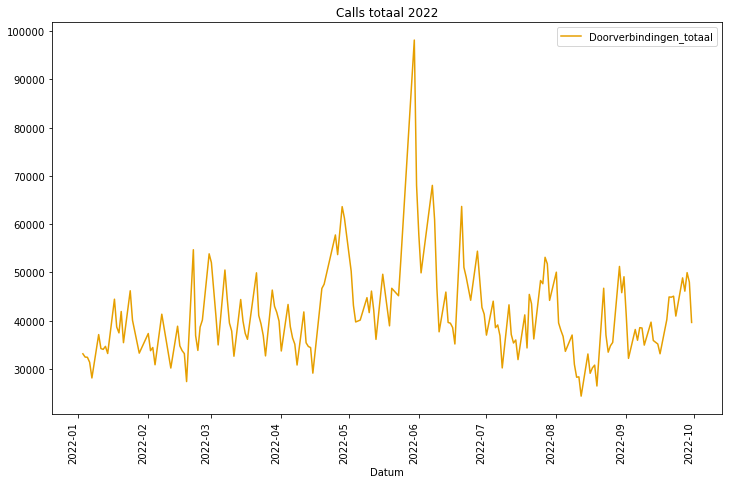

In [24]:
plt.rc("axes", prop_cycle=line_cycler)

df_particulieren[(df_particulieren['Datum'] > pd.Timestamp(2019,1,1)) &(df_particulieren['Datum'] < pd.Timestamp(2020,1,1))]\
                .set_index('Datum')[['Doorverbindingen_totaal']]\
                .plot(title="Calls totaal 2019",figsize=(12,8))
plt.xticks(rotation = 90)

df_particulieren[(df_particulieren['Datum'] > pd.Timestamp(2020,1,1)) &(df_particulieren['Datum'] < pd.Timestamp(2021,1,1))]\
                .set_index('Datum')[['Doorverbindingen_totaal']]\
                .plot(title="Calls totaal 2020",figsize=(12,8))
plt.xticks(rotation = 90)

df_particulieren[(df_particulieren['Datum'] > pd.Timestamp(2021,1,1)) &(df_particulieren['Datum'] < pd.Timestamp(2022,1,1))]\
                .set_index('Datum')[['Doorverbindingen_totaal']]\
                .plot(title="Calls totaal 2021",figsize=(12,8))
plt.xticks(rotation = 90)

df_particulieren[(df_particulieren['Datum'] > pd.Timestamp(2022,1,1)) &(df_particulieren['Datum'] < pd.Timestamp(2023,1,1))]\
                .set_index('Datum')[['Doorverbindingen_totaal']]\
                .plot(title="Calls totaal 2022",figsize=(12,8))
plt.xticks(rotation = 90)

plt.show()

In [25]:
df_particulieren['Doorverbindingen_totaal'].mean()

42565.707659115425

/tmp/ipykernel_317/142740171.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_particulieren['SMA_calls'] = df_particulieren['Doorverbindingen_totaal'].rolling(30).mean()


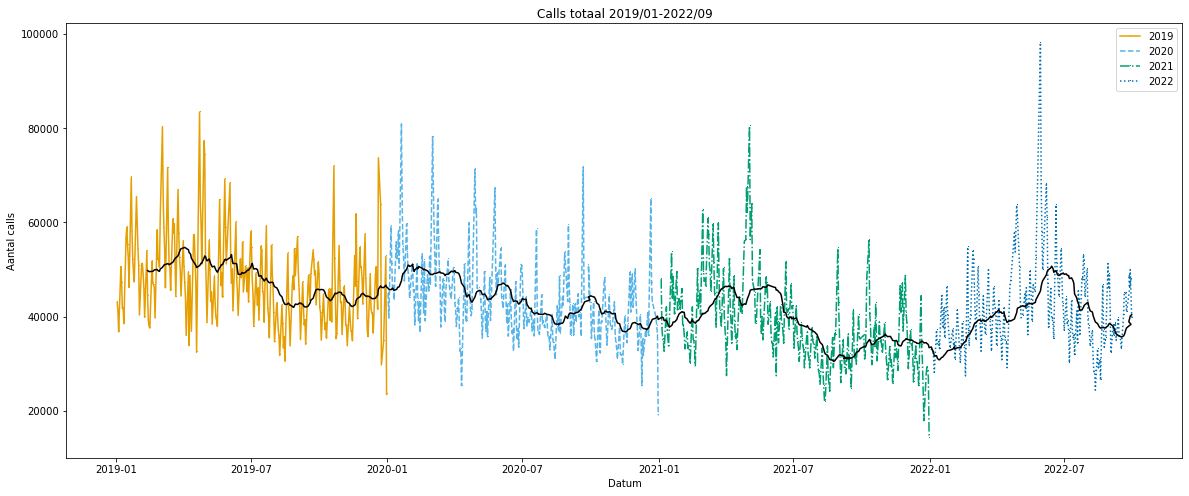

In [26]:
plt.figure(figsize = (20, 8))
plt.title('Calls totaal 2019/01-2022/09')
plt.xlabel('Datum')
plt.ylabel('Aantal calls')          

plt.plot(df_particulieren[(df_particulieren['Datum'] > pd.Timestamp(2019,1,1)) &(df_particulieren['Datum'] < pd.Timestamp(2020,1,1))].set_index('Datum')[['Doorverbindingen_totaal']],marker=',', label= '2019')
plt.plot(df_particulieren[(df_particulieren['Datum'] > pd.Timestamp(2020,1,1)) &(df_particulieren['Datum'] < pd.Timestamp(2021,1,1))].set_index('Datum')[['Doorverbindingen_totaal']],marker = ',',label = '2020')
plt.plot(df_particulieren[(df_particulieren['Datum'] > pd.Timestamp(2021,1,1)) &(df_particulieren['Datum'] < pd.Timestamp(2022,1,1))].set_index('Datum')[['Doorverbindingen_totaal']],marker = ',',label = '2021')
plt.plot(df_particulieren[(df_particulieren['Datum'] > pd.Timestamp(2022,1,1)) &(df_particulieren['Datum'] < pd.Timestamp(2023,1,1))].set_index('Datum')[['Doorverbindingen_totaal']],marker = ',',label = '2022')

df_particulieren['SMA_calls'] = df_particulieren['Doorverbindingen_totaal'].rolling(30).mean()
plt.plot(df_particulieren['Datum'], df_particulieren['SMA_calls'], color = 'black')
plt.legend()


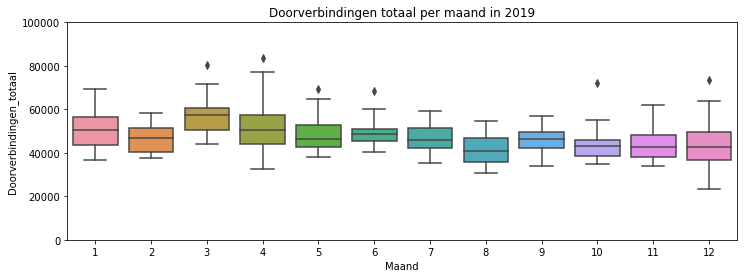

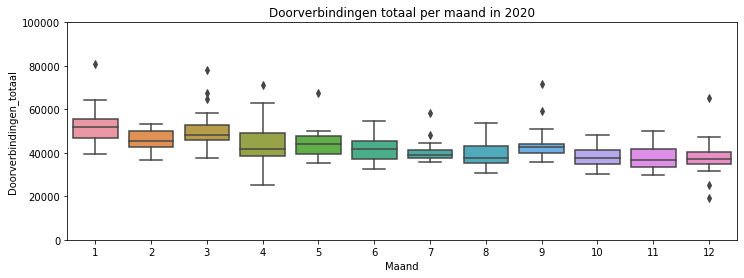

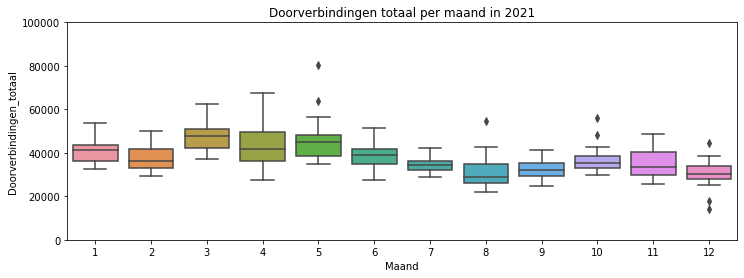

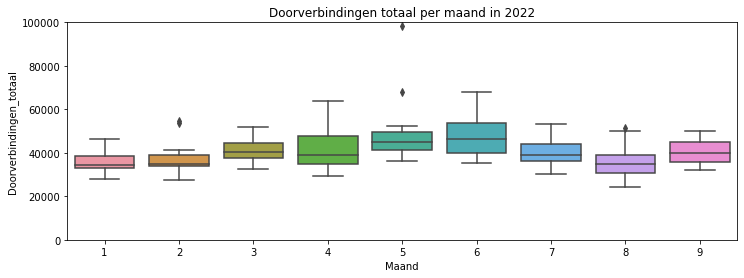

In [27]:
unieke_jaren = list(df_particulieren['Jaar'].unique())
for i, jaren in enumerate(unieke_jaren):
    fig, ax = plt.subplots()
    fig.set_size_inches((12,4))
    ax.set_ylim([0,100000])
    sns.boxplot(x = 'Maand', y = 'Doorverbindingen_totaal', data = df_particulieren[df_particulieren['Jaar'] == jaren], ax=ax)
    plt.title('Doorverbindingen totaal per maand in ' +str(unieke_jaren[i]))
    plt.show()

#### Particulieren

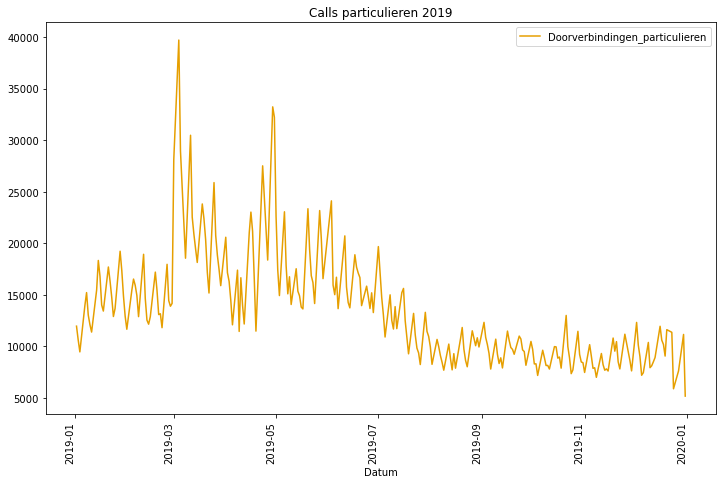

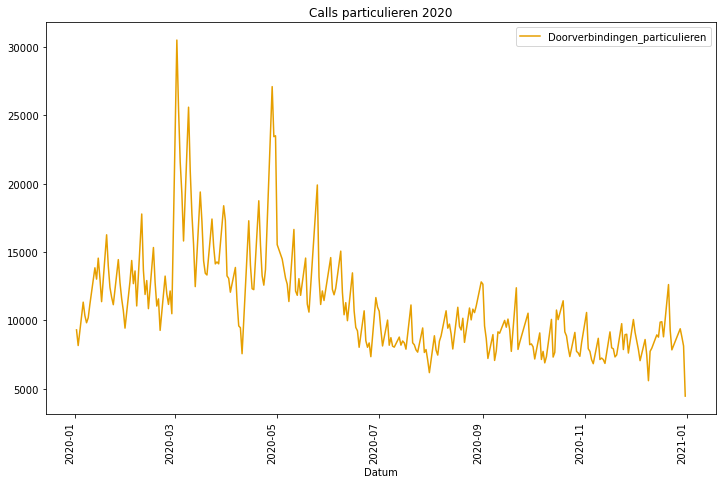

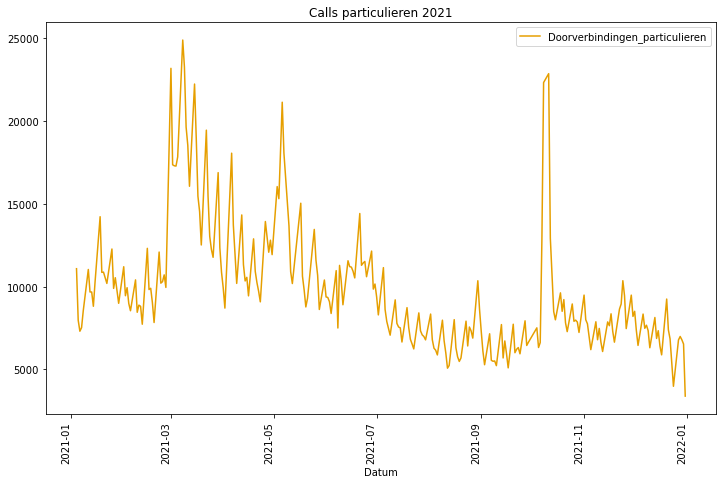

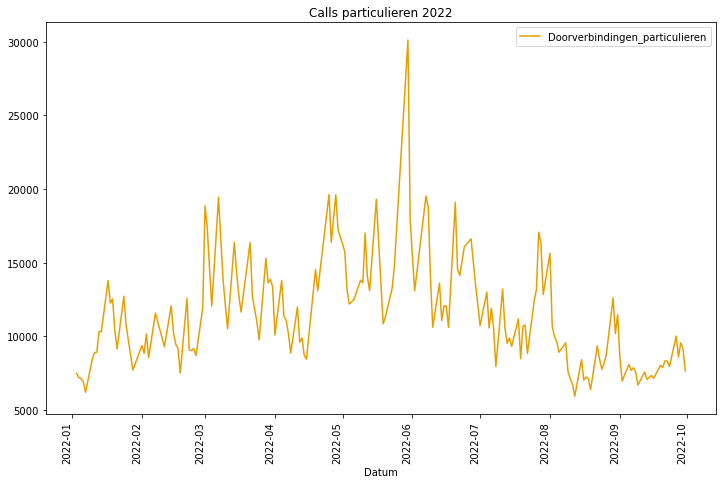

In [28]:
df_particulieren[(df_particulieren['Datum'] > pd.Timestamp(2019,1,1)) &(df_particulieren['Datum'] < pd.Timestamp(2020,1,1))]\
                .set_index('Datum')[['Doorverbindingen_particulieren']]\
                .plot(title="Calls particulieren 2019",figsize=(12,8))
plt.xticks(rotation = 90)

df_particulieren[(df_particulieren['Datum'] > pd.Timestamp(2020,1,1)) &(df_particulieren['Datum'] < pd.Timestamp(2021,1,1))]\
                .set_index('Datum')[['Doorverbindingen_particulieren']]\
                .plot(title="Calls particulieren 2020",figsize=(12,8))
plt.xticks(rotation = 90)

df_particulieren[(df_particulieren['Datum'] > pd.Timestamp(2021,1,1)) &(df_particulieren['Datum'] < pd.Timestamp(2022,1,1))]\
                .set_index('Datum')[['Doorverbindingen_particulieren']]\
                .plot(title="Calls particulieren 2021",figsize=(12,8))
plt.xticks(rotation = 90)

df_particulieren[(df_particulieren['Datum'] > pd.Timestamp(2022,1,1)) &(df_particulieren['Datum'] < pd.Timestamp(2023,1,1))]\
                .set_index('Datum')[['Doorverbindingen_particulieren']]\
                .plot(title="Calls particulieren 2022",figsize=(12,8))
plt.xticks(rotation = 90)

plt.show()

In [29]:
df_particulieren[df_particulieren['Jaar'] == '2021'][df_particulieren['Maand'] == 'Oct'][['Datum', 'Doorverbindingen_particulieren']]#.max()

/tmp/ipykernel_317/3699138767.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_particulieren[df_particulieren['Jaar'] == '2021'][df_particulieren['Maand'] == 'Oct'][['Datum', 'Doorverbindingen_particulieren']]#.max()


Empty DataFrame
Columns: [Datum, Doorverbindingen_particulieren]
Index: []

In [30]:
df_particulieren[df_particulieren['Jaar'] == '2022'][df_particulieren['Maand'] == 'Jun'][['Datum', 'Doorverbindingen_particulieren']]

/tmp/ipykernel_317/1738945677.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_particulieren[df_particulieren['Jaar'] == '2022'][df_particulieren['Maand'] == 'Jun'][['Datum', 'Doorverbindingen_particulieren']]


Empty DataFrame
Columns: [Datum, Doorverbindingen_particulieren]
Index: []

In [31]:
df_particulieren[df_particulieren['Jaar'] == '2021'][df_particulieren['Doorverbindingen_particulieren'] == 22858]

/tmp/ipykernel_317/2629224528.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_particulieren[df_particulieren['Jaar'] == '2021'][df_particulieren['Doorverbindingen_particulieren'] == 22858]


Datum  Maand  Jaar  DagvdWeek  Dag  WeekNr  \
695 2021-10-11     10  2021          0   11      41   

     Binnengekomen bij Provider  Doorgeleid naar keuzemenu  \
695                     61961.0                    61850.0   

     Door beller opgehangen in menu  Automatisch behandeld in menu  ...  \
695                         12155.0                         1753.0  ...   

     Doorverbindingen_totaal  Wachtrij_particulieren  Wachtrij_totaal  \
695                  56163.0                 14010.0          45930.0   

     Wachtrij_opgehangen_particulieren  Wachtrij_opgehangen_totaal  \
695                             5227.0                     10640.0   

     Geholpen_particulieren  Geholpen_totaal  \
695                  8771.0          35278.0   

     Gemiddelde_wachttijd_particulieren  Gemiddelde_wachttijd_totaal  \
695                              1101.0                        575.0   

     SMA_calls  
695    34985.2  

[1 rows x 22 columns]

In [32]:
df_particulieren['Doorverbindingen_particulieren'].mean()

11437.251348435815

/tmp/ipykernel_317/3727512622.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_particulieren['SMA_calls'] = df_particulieren['Doorverbindingen_particulieren'].rolling(30).mean()


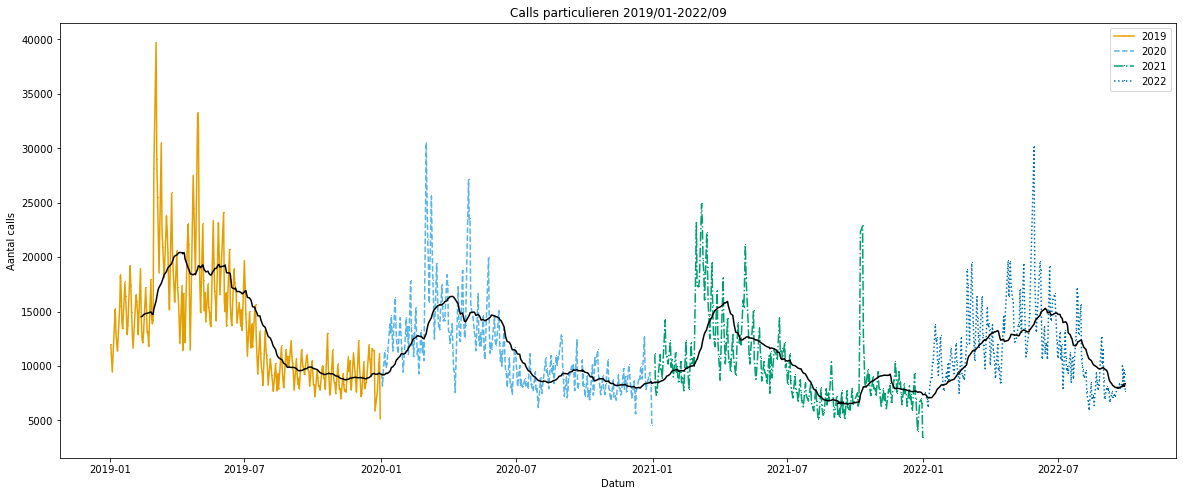

In [33]:
plt.figure(figsize = (20, 8))
plt.title('Calls particulieren 2019/01-2022/09')
plt.xlabel('Datum')
plt.ylabel('Aantal calls')
#plt.ylim(0,42000)

plt.plot(df_particulieren[(df_particulieren['Datum'] > pd.Timestamp(2019,1,1)) &(df_particulieren['Datum'] < pd.Timestamp(2020,1,1))].set_index('Datum')[['Doorverbindingen_particulieren']],marker=',', label= '2019')
plt.plot(df_particulieren[(df_particulieren['Datum'] > pd.Timestamp(2020,1,1)) &(df_particulieren['Datum'] < pd.Timestamp(2021,1,1))].set_index('Datum')[['Doorverbindingen_particulieren']],marker = ',', label = '2020')
plt.plot(df_particulieren[(df_particulieren['Datum'] > pd.Timestamp(2021,1,1)) &(df_particulieren['Datum'] < pd.Timestamp(2022,1,1))].set_index('Datum')[['Doorverbindingen_particulieren']],marker = ',', label = '2021')
plt.plot(df_particulieren[(df_particulieren['Datum'] > pd.Timestamp(2022,1,1)) &(df_particulieren['Datum'] < pd.Timestamp(2023,1,1))].set_index('Datum')[['Doorverbindingen_particulieren']],marker = ',', label = '2022')

df_particulieren['SMA_calls'] = df_particulieren['Doorverbindingen_particulieren'].rolling(30).mean()
plt.plot(df_particulieren['Datum'], df_particulieren['SMA_calls'], color = 'black')
plt.legend()

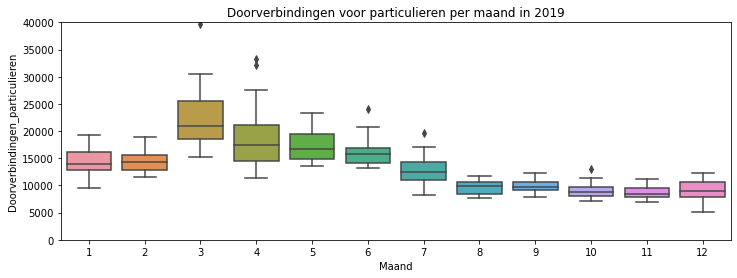

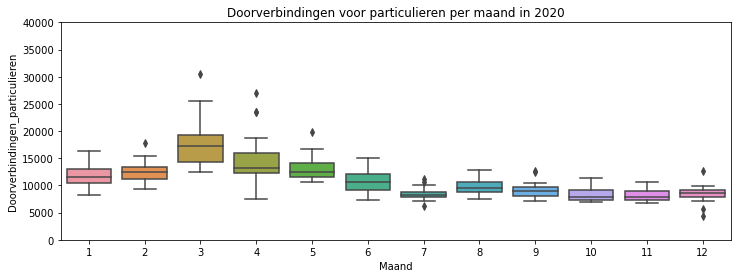

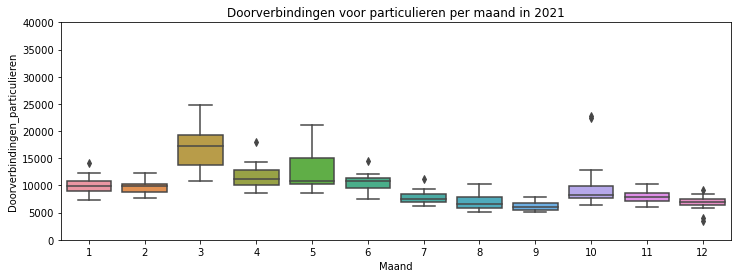

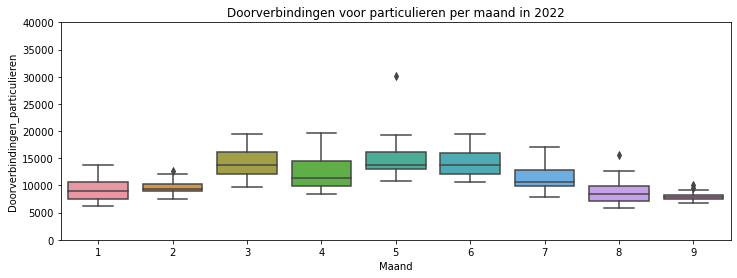

In [34]:
unieke_jaren = list(df_particulieren['Jaar'].unique())
for i, jaren in enumerate(unieke_jaren):
    fig, ax = plt.subplots()
    fig.set_size_inches((12,4))
    ax.set_ylim([0,40000])
    sns.boxplot(x = 'Maand', y = 'Doorverbindingen_particulieren', data = df_particulieren[df_particulieren['Jaar'] == jaren], ax=ax)
    plt.title('Doorverbindingen voor particulieren per maand in ' +str(unieke_jaren[i]))
    plt.show()

#### Ondernemingen

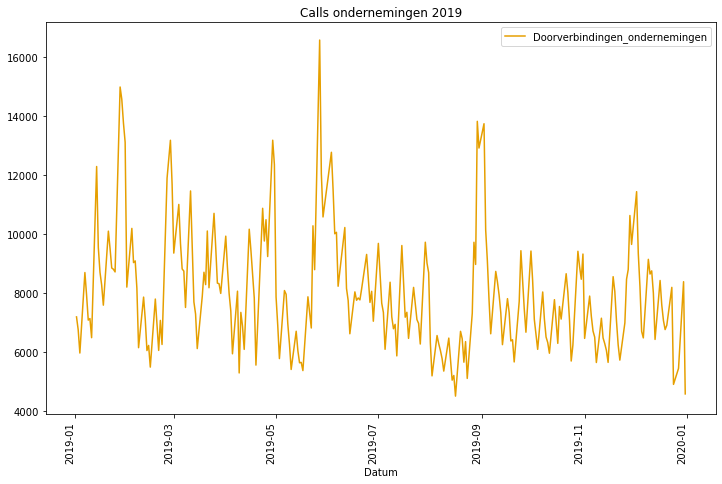

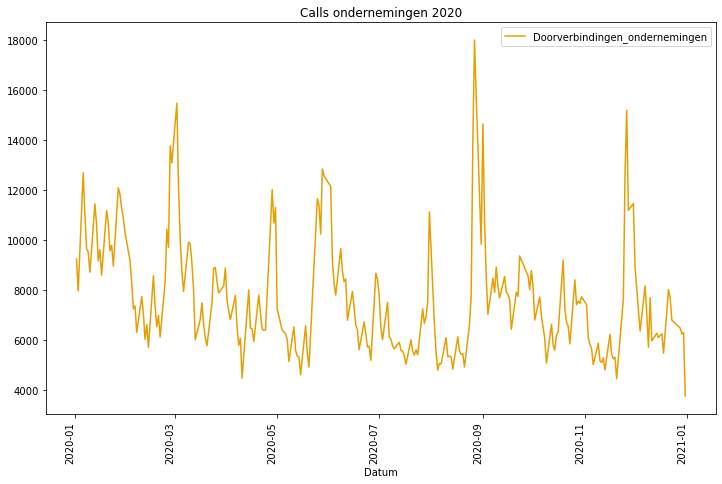

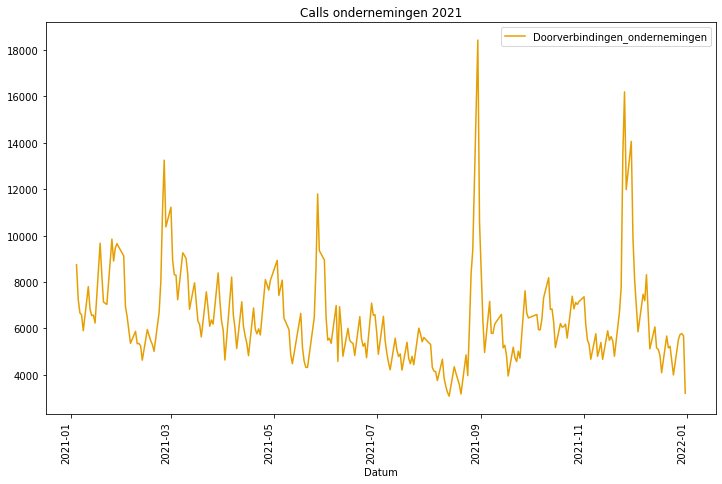

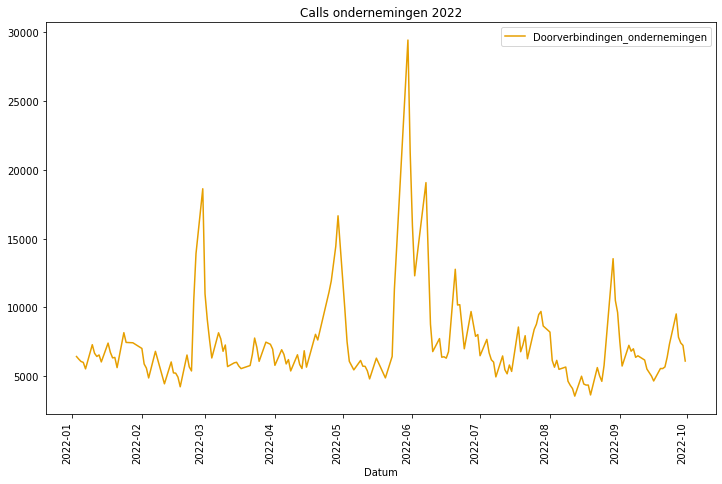

In [35]:
df_ondernemingen[(df_ondernemingen['Datum'] > pd.Timestamp(2019,1,1)) &(df_ondernemingen['Datum'] < pd.Timestamp(2020,1,1))]\
                .set_index('Datum')[['Doorverbindingen_ondernemingen']]\
                .plot(title="Calls ondernemingen 2019",figsize=(12,8))
plt.xticks(rotation = 90)

df_ondernemingen[(df_ondernemingen['Datum'] > pd.Timestamp(2020,1,1)) &(df_ondernemingen['Datum'] < pd.Timestamp(2021,1,1))]\
                .set_index('Datum')[['Doorverbindingen_ondernemingen']]\
                .plot(title="Calls ondernemingen 2020",figsize=(12,8))
plt.xticks(rotation = 90)

df_ondernemingen[(df_ondernemingen['Datum'] > pd.Timestamp(2021,1,1)) &(df_ondernemingen['Datum'] < pd.Timestamp(2022,1,1))]\
                .set_index('Datum')[['Doorverbindingen_ondernemingen']]\
                .plot(title="Calls ondernemingen 2021",figsize=(12,8))
plt.xticks(rotation = 90)

df_ondernemingen[(df_ondernemingen['Datum'] > pd.Timestamp(2022,1,1)) &(df_ondernemingen['Datum'] < pd.Timestamp(2023,1,1))]\
                .set_index('Datum')[['Doorverbindingen_ondernemingen']]\
                .plot(title="Calls ondernemingen 2022",figsize=(12,8))
plt.xticks(rotation = 90)

plt.show()


/tmp/ipykernel_317/4211696712.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_ondernemingen['SMA_calls'] = df_ondernemingen['Doorverbindingen_ondernemingen'].rolling(30).mean()


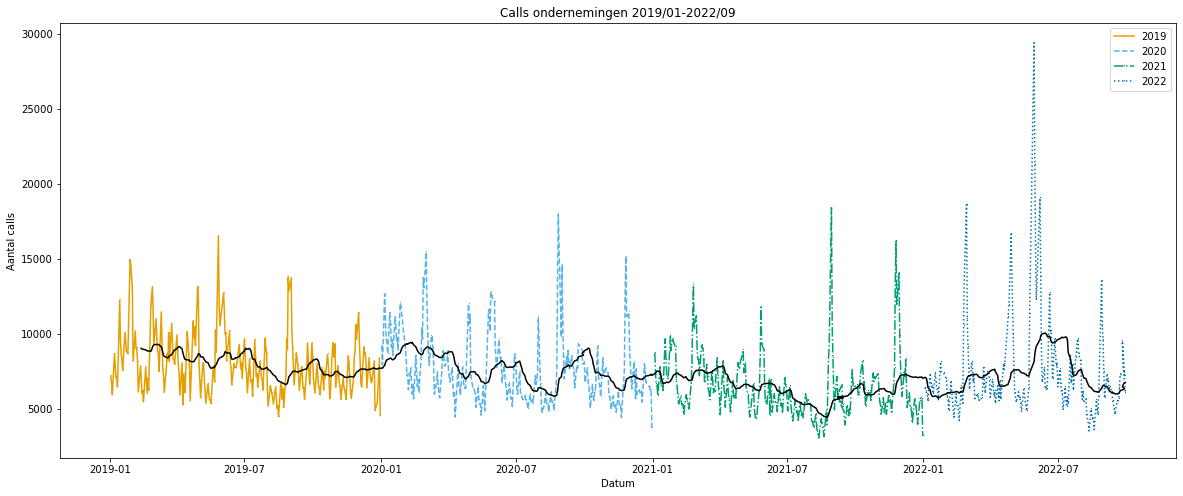

In [36]:
plt.figure(figsize = (20, 8))
plt.title('Calls ondernemingen 2019/01-2022/09')
plt.xlabel('Datum')
plt.ylabel('Aantal calls')
#plt.ylim(0,42000)

plt.plot(df_ondernemingen[(df_ondernemingen['Datum'] > pd.Timestamp(2019,1,1)) &(df_ondernemingen['Datum'] < pd.Timestamp(2020,1,1))].set_index('Datum')[['Doorverbindingen_ondernemingen']],marker=',', label= '2019')
plt.plot(df_ondernemingen[(df_ondernemingen['Datum'] > pd.Timestamp(2020,1,1)) &(df_ondernemingen['Datum'] < pd.Timestamp(2021,1,1))].set_index('Datum')[['Doorverbindingen_ondernemingen']],marker = ',', label = '2020')
plt.plot(df_ondernemingen[(df_ondernemingen['Datum'] > pd.Timestamp(2021,1,1)) &(df_ondernemingen['Datum'] < pd.Timestamp(2022,1,1))].set_index('Datum')[['Doorverbindingen_ondernemingen']],marker = ',', label = '2021')
plt.plot(df_ondernemingen[(df_ondernemingen['Datum'] > pd.Timestamp(2022,1,1)) &(df_ondernemingen['Datum'] < pd.Timestamp(2023,1,1))].set_index('Datum')[['Doorverbindingen_ondernemingen']],marker = ',', label = '2022')

df_ondernemingen['SMA_calls'] = df_ondernemingen['Doorverbindingen_ondernemingen'].rolling(30).mean()
plt.plot(df_ondernemingen['Datum'], df_ondernemingen['SMA_calls'], color = 'black')

plt.legend()
# seasonality, residual and randomness

In [37]:
df_ondernemingen['Doorverbindingen_ondernemingen'].mean()

7373.44120819849

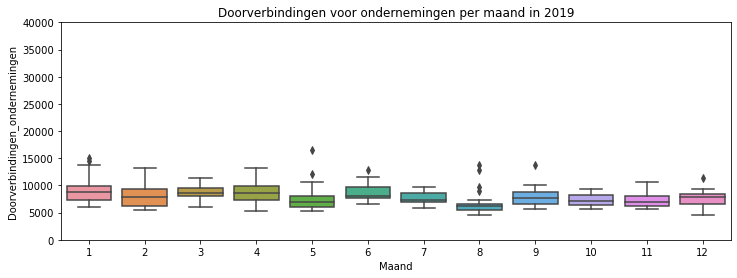

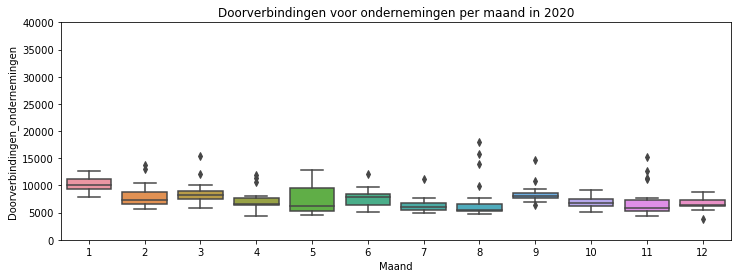

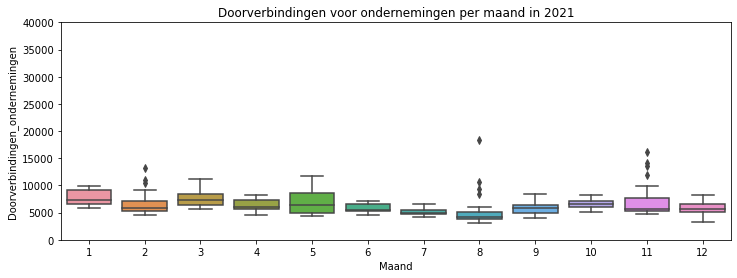

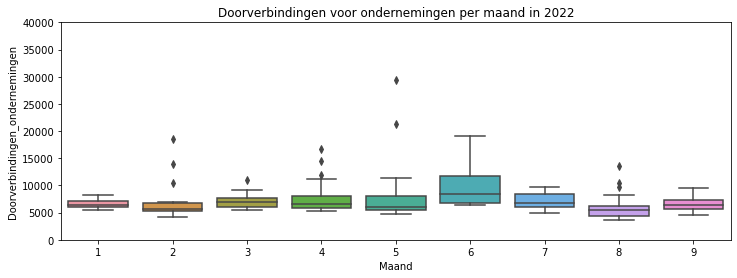

In [38]:
unieke_jaren = list(df_ondernemingen['Jaar'].unique())
for i, jaren in enumerate(unieke_jaren):
    fig, ax = plt.subplots()
    fig.set_size_inches((12,4))
    ax.set_ylim([0,40000])
    sns.boxplot(x = 'Maand', y = 'Doorverbindingen_ondernemingen', data = df_ondernemingen[df_ondernemingen['Jaar'] == jaren], ax=ax)
    plt.title('Doorverbindingen voor ondernemingen per maand in ' +str(unieke_jaren[i]))
    plt.show()

#### Intermediairs

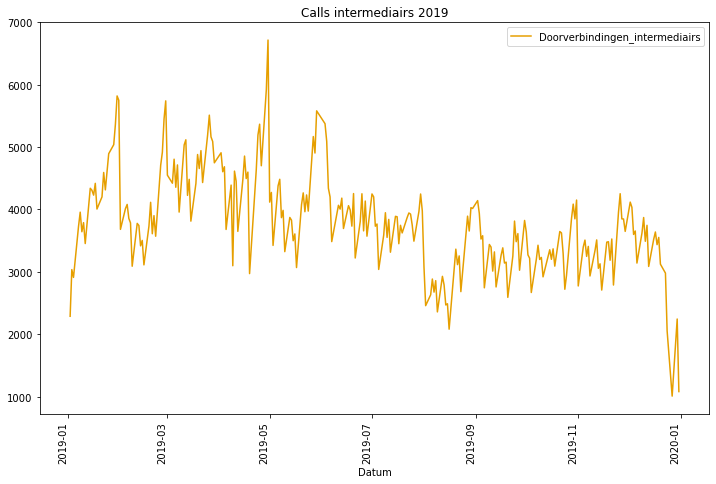

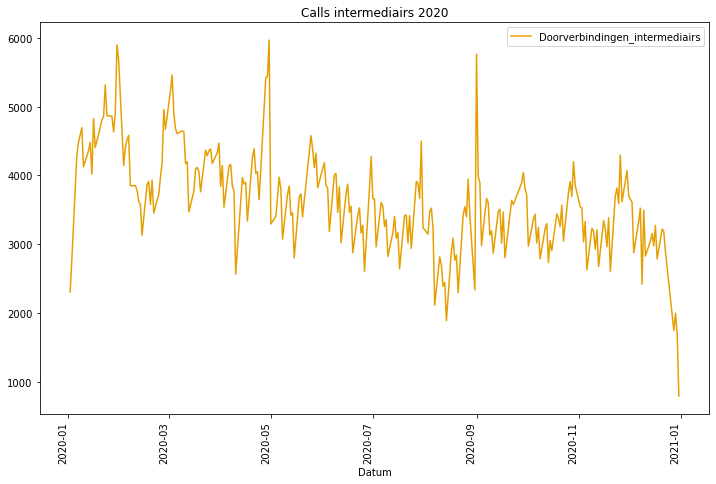

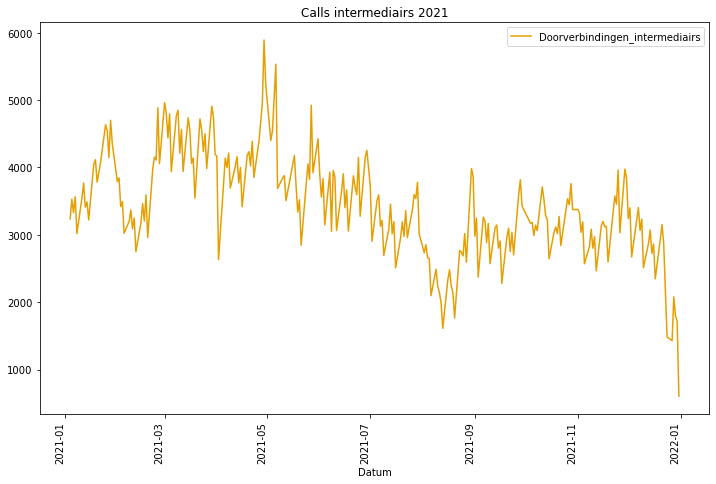

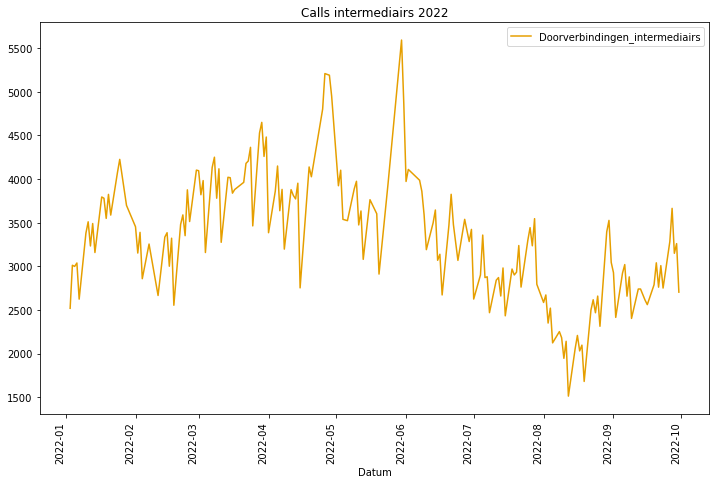

In [39]:
df_intermediairs[(df_intermediairs['Datum'] > pd.Timestamp(2019,1,1)) &(df_intermediairs['Datum'] < pd.Timestamp(2020,1,1))]\
                .set_index('Datum')[['Doorverbindingen_intermediairs']]\
                .plot(title="Calls intermediairs 2019",figsize=(12,8))
plt.xticks(rotation = 90)

df_intermediairs[(df_intermediairs['Datum'] > pd.Timestamp(2020,1,1)) &(df_intermediairs['Datum'] < pd.Timestamp(2021,1,1))]\
                .set_index('Datum')[['Doorverbindingen_intermediairs']]\
                .plot(title="Calls intermediairs 2020",figsize=(12,8))
plt.xticks(rotation = 90)

df_intermediairs[(df_intermediairs['Datum'] > pd.Timestamp(2021,1,1)) &(df_intermediairs['Datum'] < pd.Timestamp(2022,1,1))]\
                .set_index('Datum')[['Doorverbindingen_intermediairs']]\
                .plot(title="Calls intermediairs 2021",figsize=(12,8))
plt.xticks(rotation = 90)

df_intermediairs[(df_intermediairs['Datum'] > pd.Timestamp(2022,1,1)) &(df_intermediairs['Datum'] < pd.Timestamp(2023,1,1))]\
                .set_index('Datum')[['Doorverbindingen_intermediairs']]\
                .plot(title="Calls intermediairs 2022",figsize=(12,8))
plt.xticks(rotation = 90)

plt.show()

In [40]:
df_intermediairs['Doorverbindingen_intermediairs'].mean()

3572.8274002157495

/tmp/ipykernel_317/273494049.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_intermediairs['SMA_calls'] = df_intermediairs['Doorverbindingen_intermediairs'].rolling(30).mean()


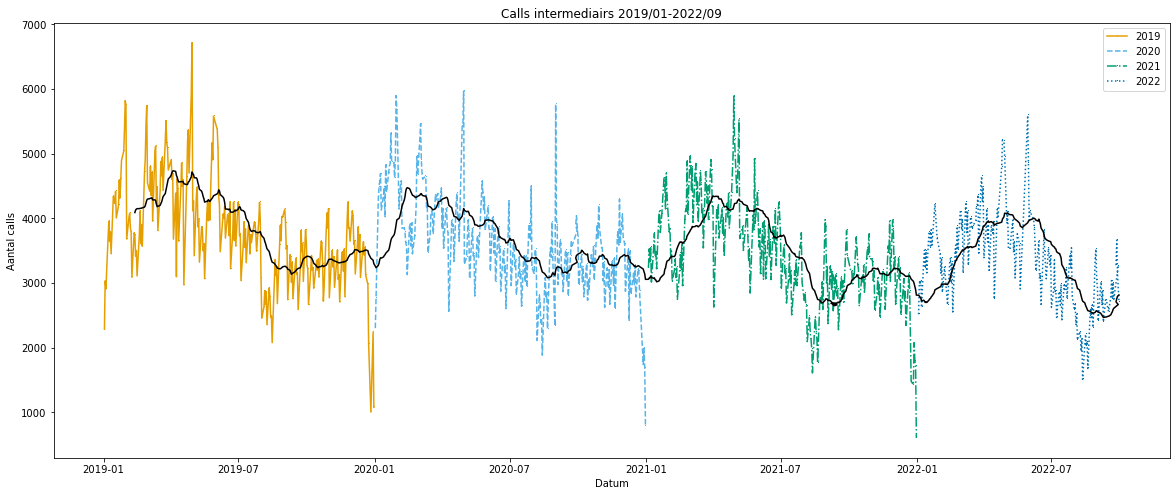

In [41]:
plt.figure(figsize = (20, 8))
plt.title('Calls intermediairs 2019/01-2022/09')
plt.xlabel('Datum')
plt.ylabel('Aantal calls')
#plt.ylim(0,42000)

plt.plot(df_intermediairs[(df_intermediairs['Datum'] > pd.Timestamp(2019,1,1)) &(df_intermediairs['Datum'] < pd.Timestamp(2020,1,1))].set_index('Datum')[['Doorverbindingen_intermediairs']],marker=',', label= '2019')
plt.plot(df_intermediairs[(df_intermediairs['Datum'] > pd.Timestamp(2020,1,1)) &(df_intermediairs['Datum'] < pd.Timestamp(2021,1,1))].set_index('Datum')[['Doorverbindingen_intermediairs']],marker = ',', label = '2020')
plt.plot(df_intermediairs[(df_intermediairs['Datum'] > pd.Timestamp(2021,1,1)) &(df_intermediairs['Datum'] < pd.Timestamp(2022,1,1))].set_index('Datum')[['Doorverbindingen_intermediairs']],marker = ',', label = '2021')
plt.plot(df_intermediairs[(df_intermediairs['Datum'] > pd.Timestamp(2022,1,1)) &(df_intermediairs['Datum'] < pd.Timestamp(2023,1,1))].set_index('Datum')[['Doorverbindingen_intermediairs']],marker = ',', label = '2022')

df_intermediairs['SMA_calls'] = df_intermediairs['Doorverbindingen_intermediairs'].rolling(30).mean()
plt.plot(df_intermediairs['Datum'], df_intermediairs['SMA_calls'], color = 'black')

plt.legend()

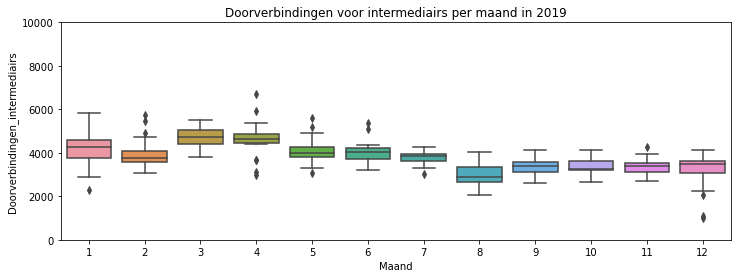

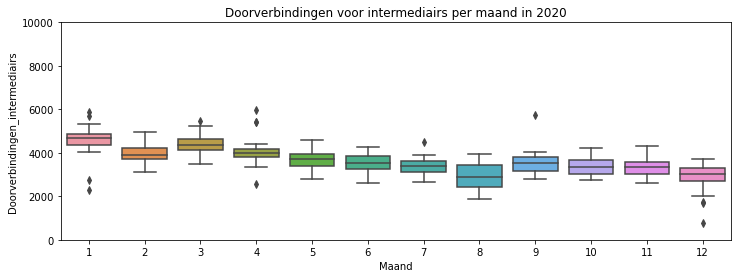

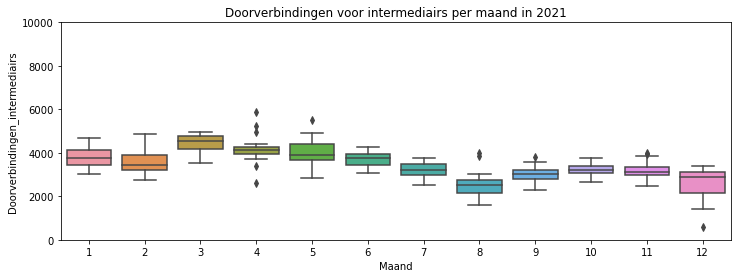

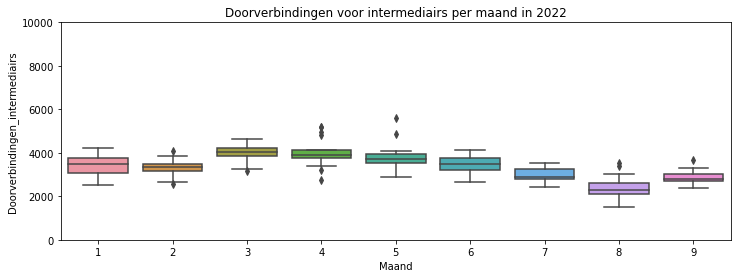

In [42]:
unieke_jaren = list(df_intermediairs['Jaar'].unique())
for i, jaren in enumerate(unieke_jaren):
    fig, ax = plt.subplots()
    fig.set_size_inches((12,4))
    ax.set_ylim([0,10000])
    sns.boxplot(x = 'Maand', y = 'Doorverbindingen_intermediairs', data = df_intermediairs[df_intermediairs['Jaar'] == jaren], ax=ax)
    plt.title('Doorverbindingen voor intermediairs per maand in ' +str(unieke_jaren[i]))
    plt.show()

#### Toeslagen

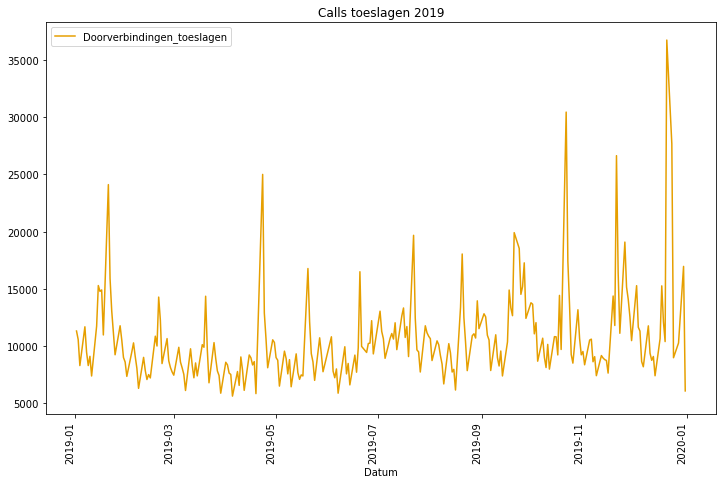

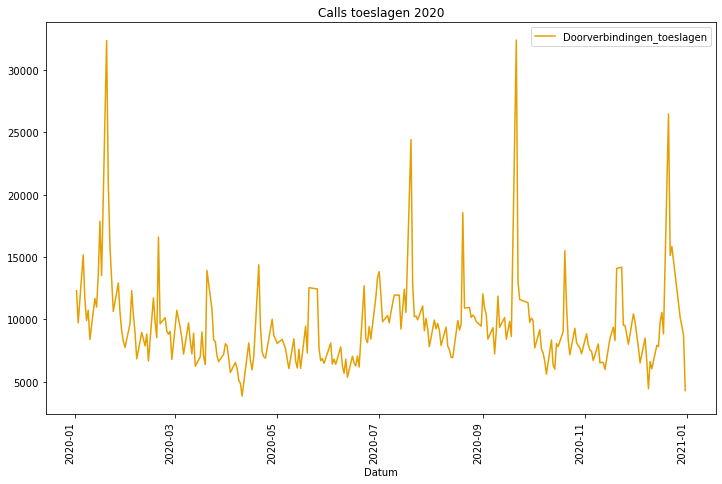

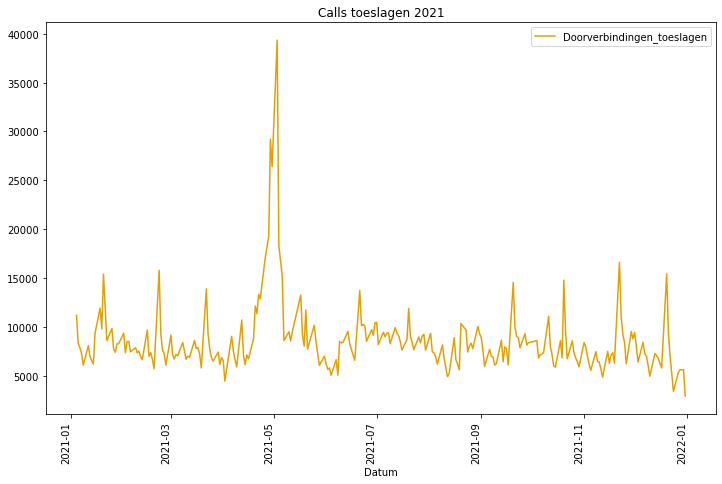

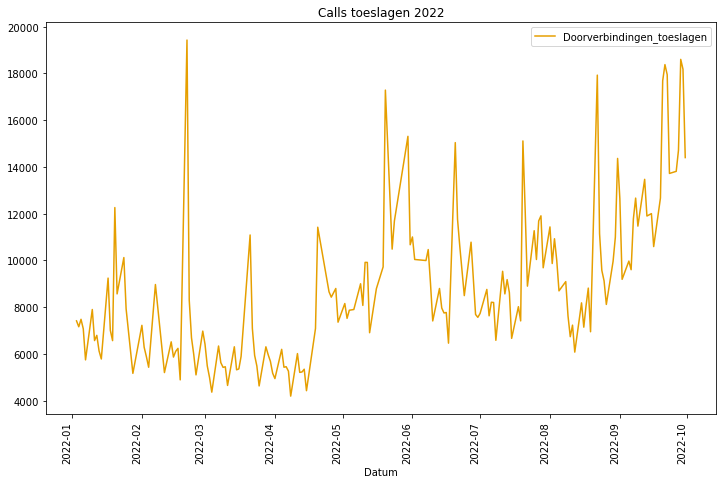

In [43]:
df_toeslagen[(df_toeslagen['Datum'] > pd.Timestamp(2019,1,1)) &(df_toeslagen['Datum'] < pd.Timestamp(2020,1,1))]\
                .set_index('Datum')[['Doorverbindingen_toeslagen']]\
                .plot(title="Calls toeslagen 2019",figsize=(12,8))
plt.xticks(rotation = 90)

df_toeslagen[(df_toeslagen['Datum'] > pd.Timestamp(2020,1,1)) &(df_toeslagen['Datum'] < pd.Timestamp(2021,1,1))]\
                .set_index('Datum')[['Doorverbindingen_toeslagen']]\
                .plot(title="Calls toeslagen 2020",figsize=(12,8))
plt.xticks(rotation = 90)

df_toeslagen[(df_toeslagen['Datum'] > pd.Timestamp(2021,1,1)) &(df_toeslagen['Datum'] < pd.Timestamp(2022,1,1))]\
                .set_index('Datum')[['Doorverbindingen_toeslagen']]\
                .plot(title="Calls toeslagen 2021",figsize=(12,8))
plt.xticks(rotation = 90)

df_toeslagen[(df_toeslagen['Datum'] > pd.Timestamp(2022,1,1)) &(df_toeslagen['Datum'] < pd.Timestamp(2023,1,1))]\
                .set_index('Datum')[['Doorverbindingen_toeslagen']]\
                .plot(title="Calls toeslagen 2022",figsize=(12,8))
plt.xticks(rotation = 90)

plt.show()

In [44]:
print('mean: ', df_toeslagen['Doorverbindingen_toeslagen'].mean())
print('max: ', df_toeslagen['Doorverbindingen_toeslagen'].max())
print('min: ', df_toeslagen['Doorverbindingen_toeslagen'].min())

mean:  9381.85436893204
max:  39353.0
min:  2916.0


In [45]:
df_toeslagen[df_toeslagen['Doorverbindingen_toeslagen'] == df_toeslagen['Doorverbindingen_toeslagen'].max()]

Datum  Maand  Jaar  DagvdWeek  Dag  WeekNr  \
586 2021-05-03      5  2021          0    3      18   

     Binnengekomen bij Provider  Doorgeleid naar keuzemenu  \
586                     79489.0                    79411.0   

     Door beller opgehangen in menu  Automatisch behandeld in menu  ...  \
586                          7355.0                         5223.0  ...   

     Doorverbindingen_toeslagen  Doorverbindingen_totaal  Wachtrij_toeslagen  \
586                     39353.0                  80453.0              9053.0   

     Wachtrij_totaal  Wachtrij_opgehangen_toeslagen  \
586          50054.0                          783.0   

     Wachtrij_opgehangen_totaal  Geholpen_toeslagen  Geholpen_totaal  \
586                      2716.0              8270.0          47316.0   

     Gemiddelde_wachttijd_toeslagen  Gemiddelde_wachttijd_totaal  
586                           438.0                        219.0  

[1 rows x 21 columns]

In [46]:
df_toeslagen[df_toeslagen['Jaar'] == '2019'][df_toeslagen['Maand'] == 'Dec']

/tmp/ipykernel_317/3012785604.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_toeslagen[df_toeslagen['Jaar'] == '2019'][df_toeslagen['Maand'] == 'Dec']


Empty DataFrame
Columns: [Datum, Maand, Jaar, DagvdWeek, Dag, WeekNr, Binnengekomen bij Provider, Doorgeleid naar keuzemenu, Door beller opgehangen in menu, Automatisch behandeld in menu, ComplexityScore_ondernemingen, Doorverbindingen_toeslagen, Doorverbindingen_totaal, Wachtrij_toeslagen, Wachtrij_totaal, Wachtrij_opgehangen_toeslagen, Wachtrij_opgehangen_totaal, Geholpen_toeslagen, Geholpen_totaal, Gemiddelde_wachttijd_toeslagen, Gemiddelde_wachttijd_totaal]
Index: []

[0 rows x 21 columns]

/tmp/ipykernel_317/1438997120.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_toeslagen['SMA_calls'] = df_toeslagen['Doorverbindingen_toeslagen'].rolling(30).mean()


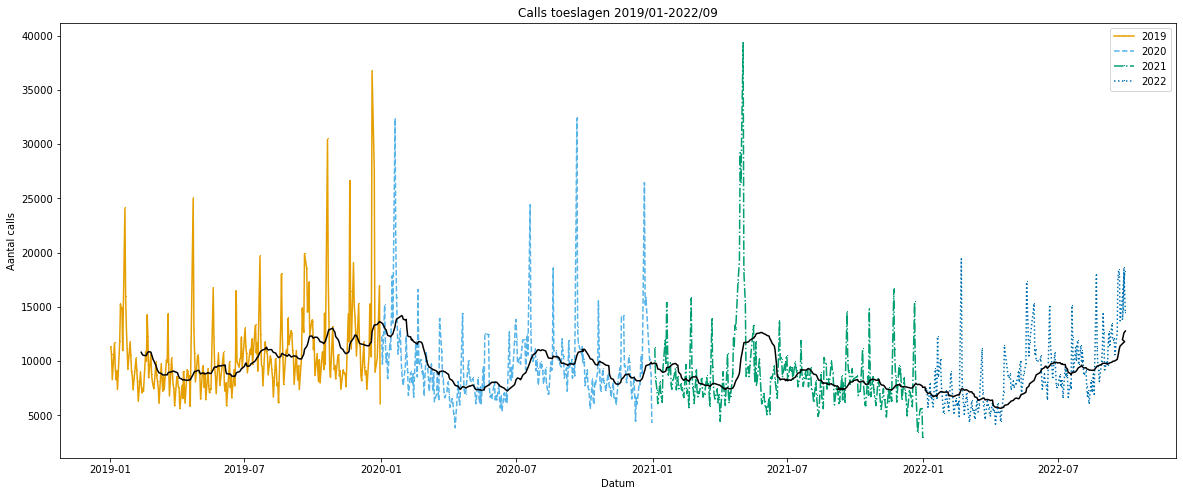

In [47]:
plt.figure(figsize = (20, 8))
plt.title('Calls toeslagen 2019/01-2022/09')
plt.xlabel('Datum')
plt.ylabel('Aantal calls')
#plt.ylim(0,42000)

plt.plot(df_toeslagen[(df_toeslagen['Datum'] > pd.Timestamp(2019,1,1)) &(df_toeslagen['Datum'] < pd.Timestamp(2020,1,1))].set_index('Datum')[['Doorverbindingen_toeslagen']],marker=',', label= '2019')
plt.plot(df_toeslagen[(df_toeslagen['Datum'] > pd.Timestamp(2020,1,1)) &(df_toeslagen['Datum'] < pd.Timestamp(2021,1,1))].set_index('Datum')[['Doorverbindingen_toeslagen']],marker = ',', label = '2020')
plt.plot(df_toeslagen[(df_toeslagen['Datum'] > pd.Timestamp(2021,1,1)) &(df_toeslagen['Datum'] < pd.Timestamp(2022,1,1))].set_index('Datum')[['Doorverbindingen_toeslagen']],marker = ',', label = '2021')
plt.plot(df_toeslagen[(df_toeslagen['Datum'] > pd.Timestamp(2022,1,1)) &(df_toeslagen['Datum'] < pd.Timestamp(2023,1,1))].set_index('Datum')[['Doorverbindingen_toeslagen']],marker = ',', label = '2022')

df_toeslagen['SMA_calls'] = df_toeslagen['Doorverbindingen_toeslagen'].rolling(30).mean()
plt.plot(df_toeslagen['Datum'], df_toeslagen['SMA_calls'], color = 'black')

plt.legend()

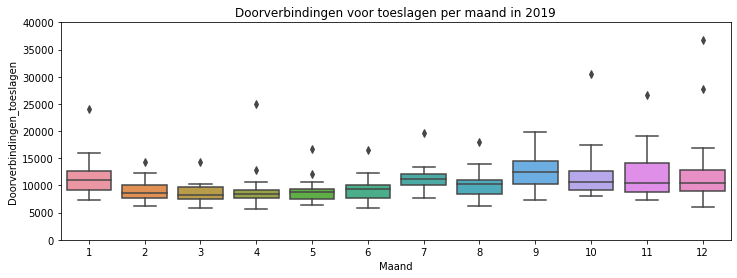

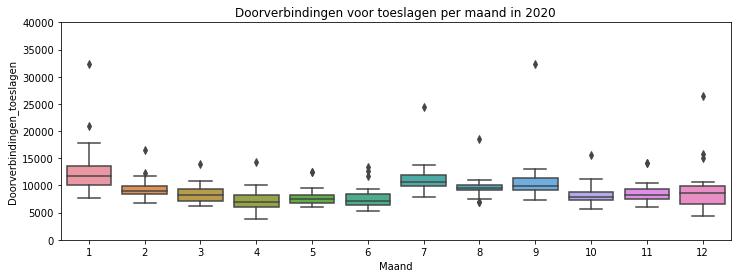

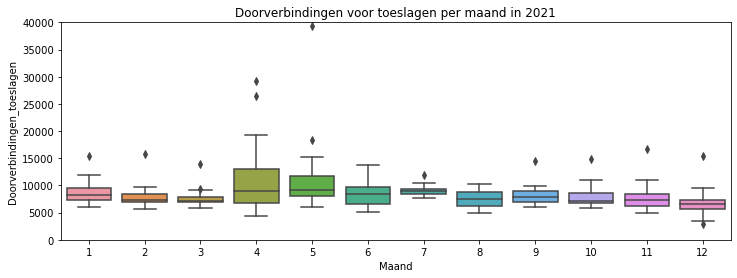

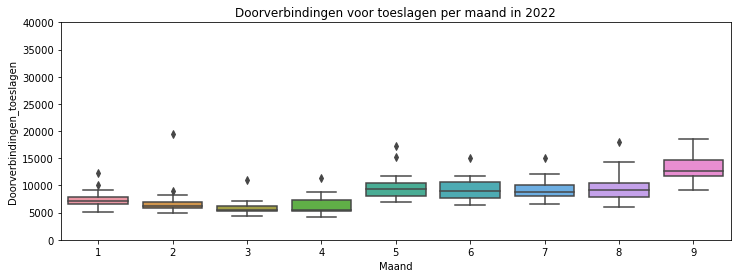

In [48]:
unieke_jaren = list(df_toeslagen['Jaar'].unique())
for i, jaren in enumerate(unieke_jaren):
    fig, ax = plt.subplots()
    fig.set_size_inches((12,4))
    ax.set_ylim([0,40000])
    sns.boxplot(x = 'Maand', y = 'Doorverbindingen_toeslagen', data = df_toeslagen[df_toeslagen['Jaar'] == jaren], ax=ax)
    plt.title('Doorverbindingen voor toeslagen per maand in ' +str(unieke_jaren[i]))
    plt.show()

#### Auto

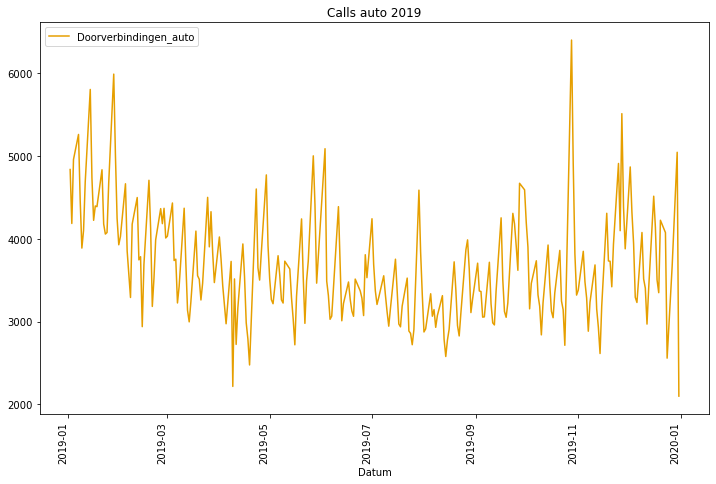

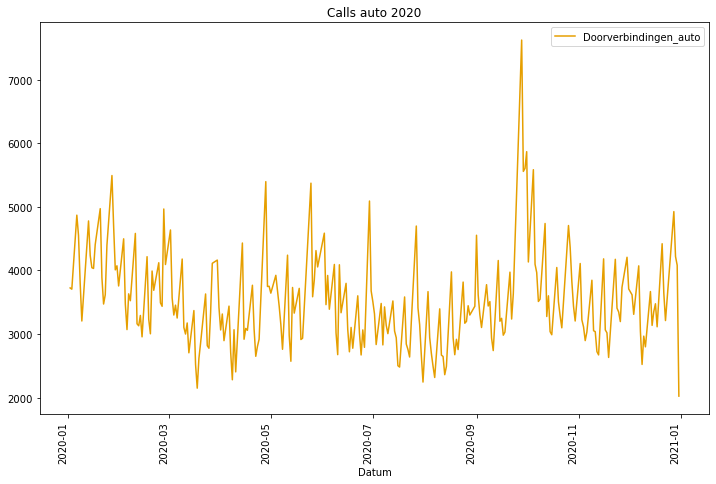

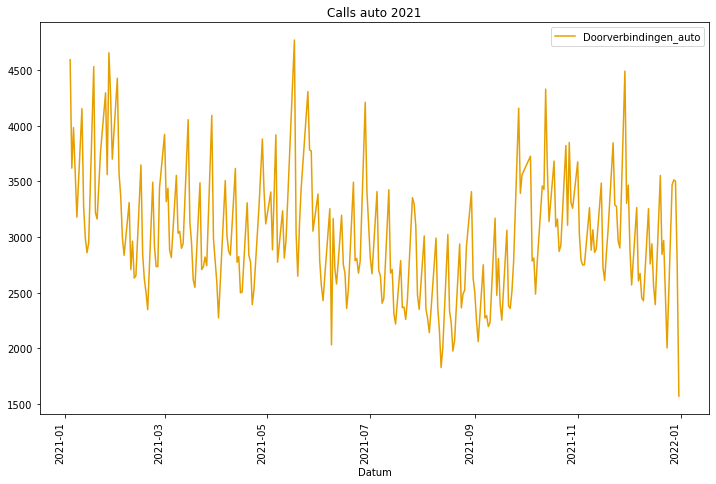

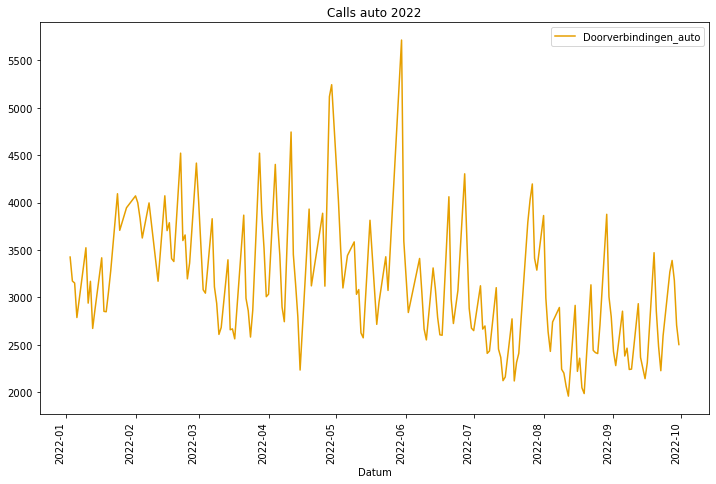

In [49]:
df_auto[(df_auto['Datum'] > pd.Timestamp(2019,1,1)) &(df_auto['Datum'] < pd.Timestamp(2020,1,1))]\
                .set_index('Datum')[['Doorverbindingen_auto']]\
                .plot(title="Calls auto 2019",figsize=(12,8))
plt.xticks(rotation = 90)

df_auto[(df_auto['Datum'] > pd.Timestamp(2020,1,1)) &(df_auto['Datum'] < pd.Timestamp(2021,1,1))]\
                .set_index('Datum')[['Doorverbindingen_auto']]\
                .plot(title="Calls auto 2020",figsize=(12,8))
plt.xticks(rotation = 90)

df_auto[(df_auto['Datum'] > pd.Timestamp(2021,1,1)) &(df_auto['Datum'] < pd.Timestamp(2022,1,1))]\
                .set_index('Datum')[['Doorverbindingen_auto']]\
                .plot(title="Calls auto 2021",figsize=(12,8))
plt.xticks(rotation = 90)

df_auto[(df_auto['Datum'] > pd.Timestamp(2022,1,1)) &(df_auto['Datum'] < pd.Timestamp(2023,1,1))]\
                .set_index('Datum')[['Doorverbindingen_auto']]\
                .plot(title="Calls auto 2022",figsize=(12,8))
plt.xticks(rotation = 90)

plt.show() 

In [50]:
print('mean: ', df_auto['Doorverbindingen_auto'].mean())
print('max: ', df_auto['Doorverbindingen_auto'].max())
print('min: ', df_auto['Doorverbindingen_auto'].min())

mean:  3328.428263214671
max:  7621.0
min:  1570.0


In [51]:
df_auto[df_auto['Doorverbindingen_auto'] == df_auto['Doorverbindingen_auto'].max()]

Datum  Maand  Jaar  DagvdWeek  Dag  WeekNr  \
439 2020-09-28      9  2020          0   28      40   

     Binnengekomen bij Provider  Doorgeleid naar keuzemenu  \
439                     45639.0                    45602.0   

     Door beller opgehangen in menu  Automatisch behandeld in menu  ...  \
439                          6001.0                         1329.0  ...   

     Doorverbindingen_auto  Doorverbindingen_totaal  Wachtrij_auto  \
439                 7621.0                  50874.0         4773.0   

     Wachtrij_totaal  Wachtrij_opgehangen_auto  Wachtrij_opgehangen_totaal  \
439          47978.0                     807.0                      3749.0   

     Geholpen_auto  Geholpen_totaal  Gemiddelde_wachttijd_auto  \
439         3966.0          44229.0                      472.0   

     Gemiddelde_wachttijd_totaal  
439                        249.0  

[1 rows x 21 columns]

/tmp/ipykernel_317/3741534026.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_auto['SMA_calls'] = df_auto['Doorverbindingen_auto'].rolling(30).mean()


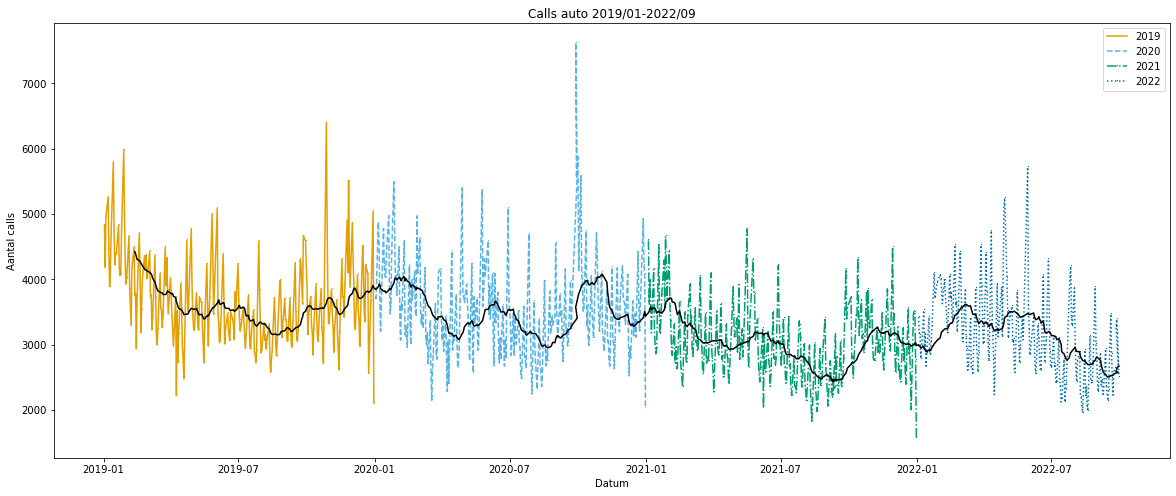

In [52]:
plt.figure(figsize = (20, 8))
plt.title('Calls auto 2019/01-2022/09')
plt.xlabel('Datum')
plt.ylabel('Aantal calls')
#plt.ylim(0,42000)

plt.plot(df_auto[(df_auto['Datum'] > pd.Timestamp(2019,1,1)) &(df_auto['Datum'] < pd.Timestamp(2020,1,1))].set_index('Datum')[['Doorverbindingen_auto']],marker=',', label= '2019')
plt.plot(df_auto[(df_auto['Datum'] > pd.Timestamp(2020,1,1)) &(df_auto['Datum'] < pd.Timestamp(2021,1,1))].set_index('Datum')[['Doorverbindingen_auto']],marker = ',', label = '2020')
plt.plot(df_auto[(df_auto['Datum'] > pd.Timestamp(2021,1,1)) &(df_auto['Datum'] < pd.Timestamp(2022,1,1))].set_index('Datum')[['Doorverbindingen_auto']],marker = ',', label = '2021')
plt.plot(df_auto[(df_auto['Datum'] > pd.Timestamp(2022,1,1)) &(df_auto['Datum'] < pd.Timestamp(2023,1,1))].set_index('Datum')[['Doorverbindingen_auto']],marker = ',', label = '2022')

df_auto['SMA_calls'] = df_auto['Doorverbindingen_auto'].rolling(30).mean()
plt.plot(df_auto['Datum'], df_auto['SMA_calls'], color = 'black')

plt.legend()

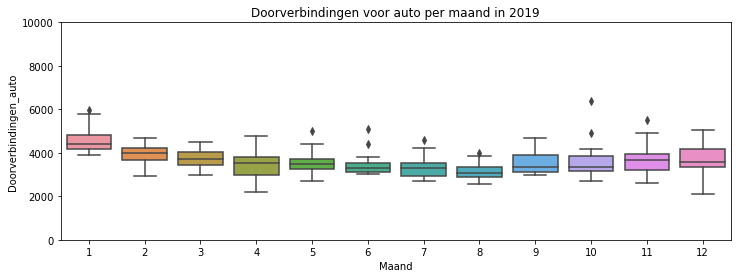

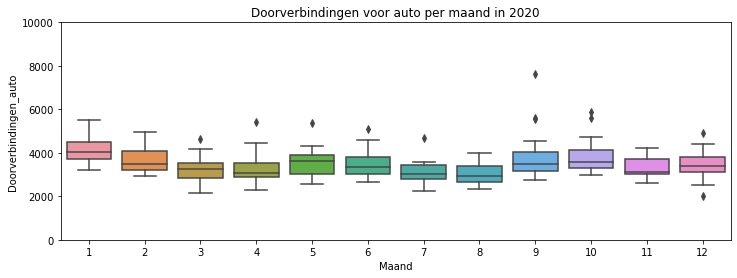

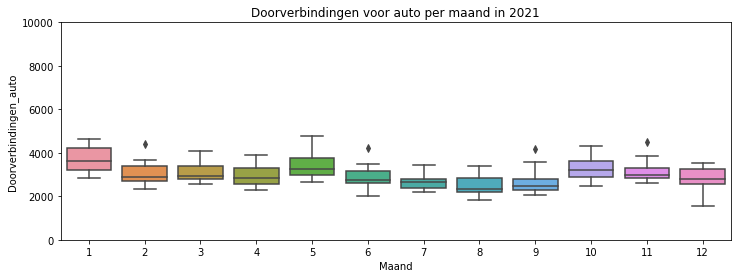

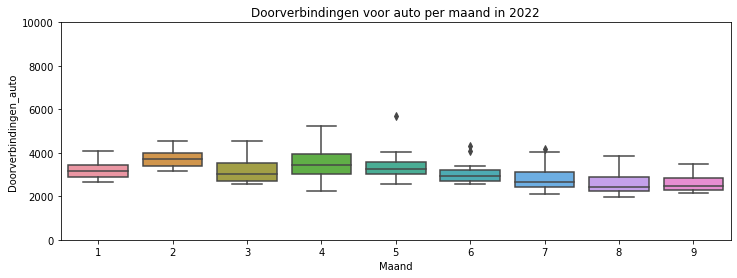

In [53]:
unieke_jaren = list(df_auto['Jaar'].unique())
for i, jaren in enumerate(unieke_jaren):
    fig, ax = plt.subplots()
    fig.set_size_inches((12,4))
    ax.set_ylim([0,10000])
    sns.boxplot(x = 'Maand', y = 'Doorverbindingen_auto', data = df_auto[df_auto['Jaar'] == jaren], ax=ax)
    plt.title('Doorverbindingen voor auto per maand in ' +str(unieke_jaren[i]))
    plt.show()

#### Buitenland

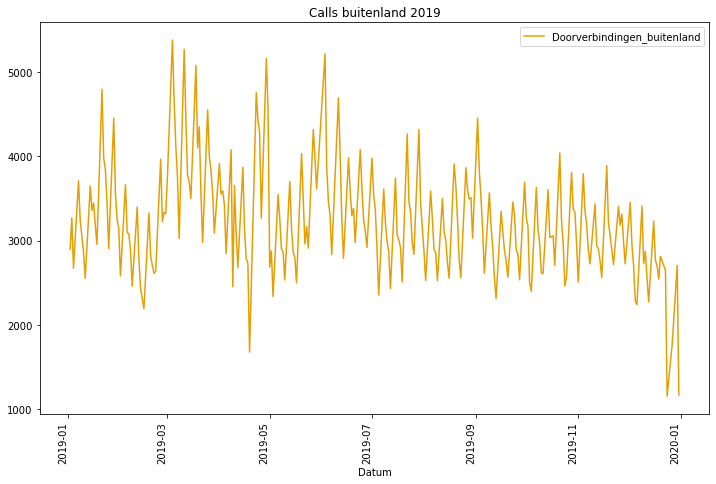

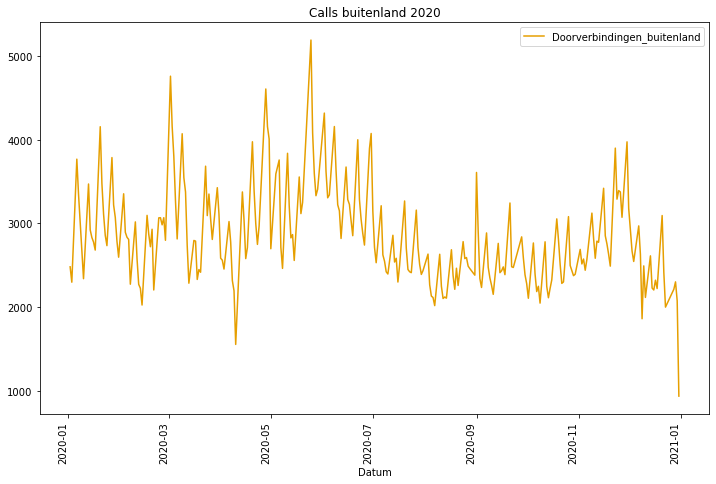

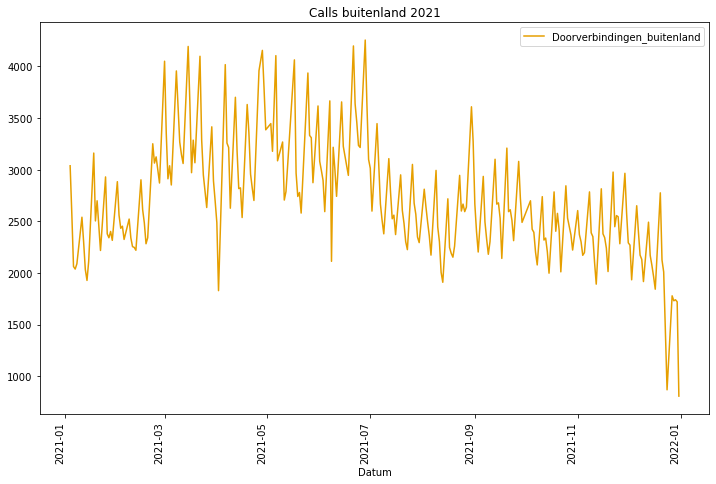

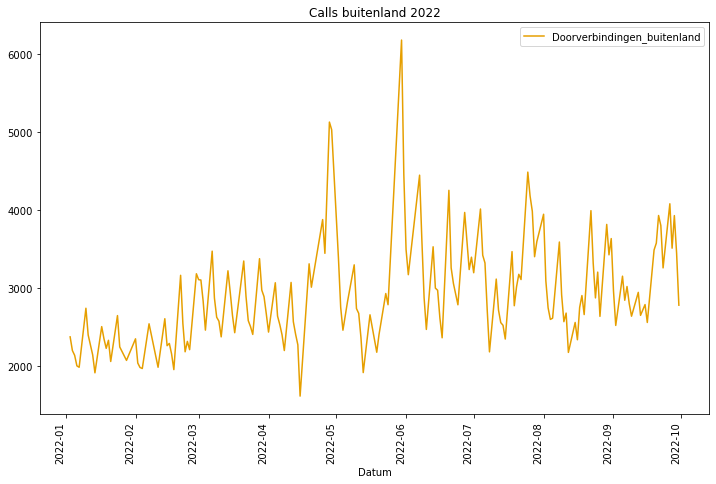

In [54]:
df_buitenland[(df_buitenland['Datum'] > pd.Timestamp(2019,1,1)) &(df_buitenland['Datum'] < pd.Timestamp(2020,1,1))]\
                .set_index('Datum')[['Doorverbindingen_buitenland']]\
                .plot(title="Calls buitenland 2019",figsize=(12,8))
plt.xticks(rotation = 90)

df_buitenland[(df_buitenland['Datum'] > pd.Timestamp(2020,1,1)) &(df_buitenland['Datum'] < pd.Timestamp(2021,1,1))]\
                .set_index('Datum')[['Doorverbindingen_buitenland']]\
                .plot(title="Calls buitenland 2020",figsize=(12,8))
plt.xticks(rotation = 90)

df_buitenland[(df_buitenland['Datum'] > pd.Timestamp(2021,1,1)) &(df_buitenland['Datum'] < pd.Timestamp(2022,1,1))]\
                .set_index('Datum')[['Doorverbindingen_buitenland']]\
                .plot(title="Calls buitenland 2021",figsize=(12,8))
plt.xticks(rotation = 90)

df_buitenland[(df_buitenland['Datum'] > pd.Timestamp(2022,1,1)) &(df_buitenland['Datum'] < pd.Timestamp(2023,1,1))]\
                .set_index('Datum')[['Doorverbindingen_buitenland']]\
                .plot(title="Calls buitenland 2022",figsize=(12,8))
plt.xticks(rotation = 90)

plt.show() 

In [55]:
print('mean: ', df_buitenland['Doorverbindingen_buitenland'].mean())
print('max: ', df_buitenland['Doorverbindingen_buitenland'].max())
print('min: ', df_buitenland['Doorverbindingen_buitenland'].min())

mean:  2920.5480043149946
max:  6175.0
min:  807.0


/tmp/ipykernel_317/2045152107.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_buitenland['SMA_calls'] = df_buitenland['Doorverbindingen_buitenland'].rolling(30).mean()


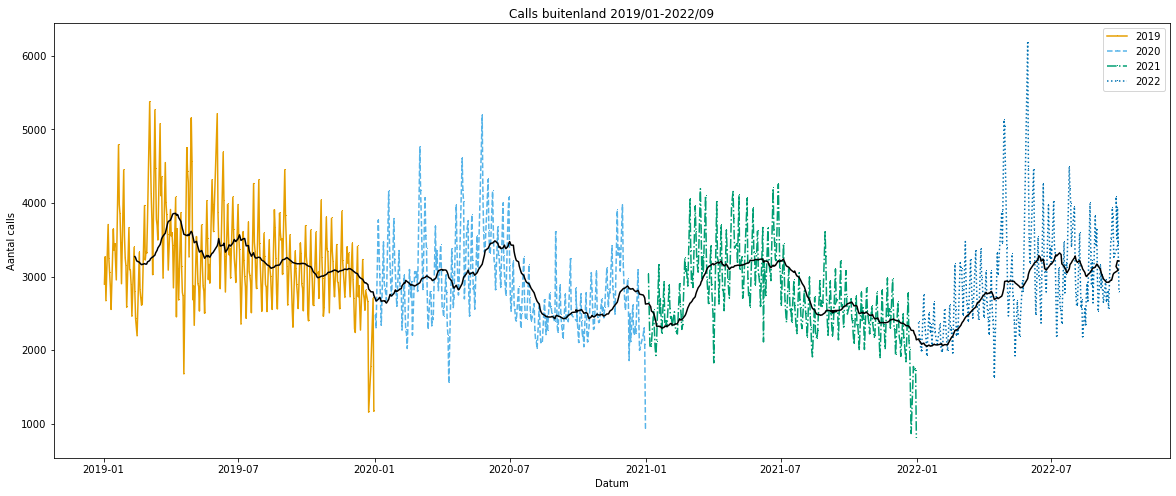

In [56]:
plt.figure(figsize = (20, 8))
plt.title('Calls buitenland 2019/01-2022/09')
plt.xlabel('Datum')
plt.ylabel('Aantal calls')
#plt.ylim(0,42000)

plt.plot(df_buitenland[(df_buitenland['Datum'] > pd.Timestamp(2019,1,1)) &(df_buitenland['Datum'] < pd.Timestamp(2020,1,1))].set_index('Datum')[['Doorverbindingen_buitenland']],marker=',', label= '2019')
plt.plot(df_buitenland[(df_buitenland['Datum'] > pd.Timestamp(2020,1,1)) &(df_buitenland['Datum'] < pd.Timestamp(2021,1,1))].set_index('Datum')[['Doorverbindingen_buitenland']],marker = ',', label = '2020')
plt.plot(df_buitenland[(df_buitenland['Datum'] > pd.Timestamp(2021,1,1)) &(df_buitenland['Datum'] < pd.Timestamp(2022,1,1))].set_index('Datum')[['Doorverbindingen_buitenland']],marker = ',', label = '2021')
plt.plot(df_buitenland[(df_buitenland['Datum'] > pd.Timestamp(2022,1,1)) &(df_buitenland['Datum'] < pd.Timestamp(2023,1,1))].set_index('Datum')[['Doorverbindingen_buitenland']],marker = ',', label = '2022')

df_buitenland['SMA_calls'] = df_buitenland['Doorverbindingen_buitenland'].rolling(30).mean()
plt.plot(df_buitenland['Datum'], df_buitenland['SMA_calls'], color = 'black')

plt.legend()

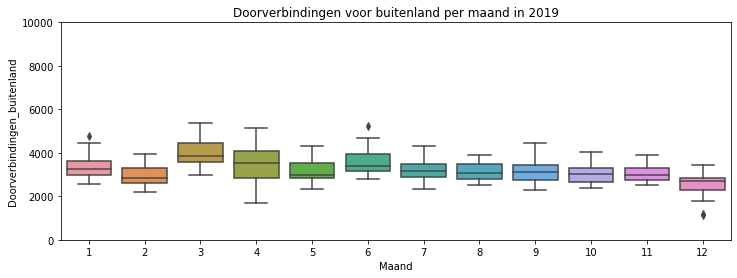

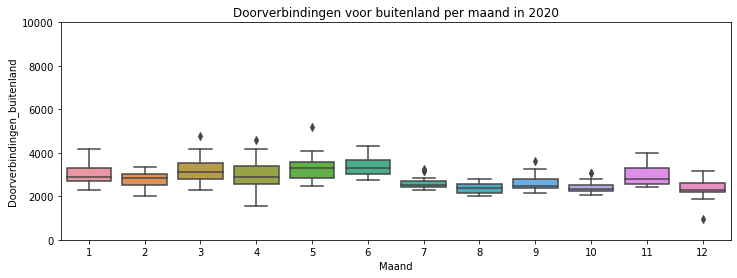

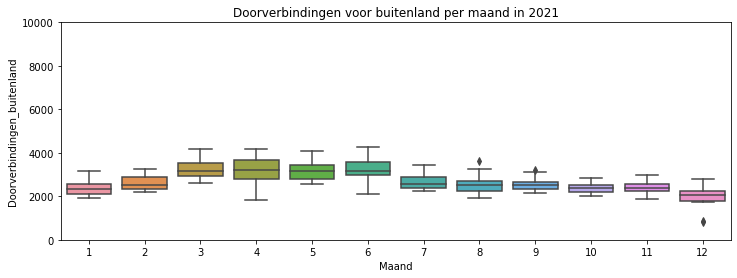

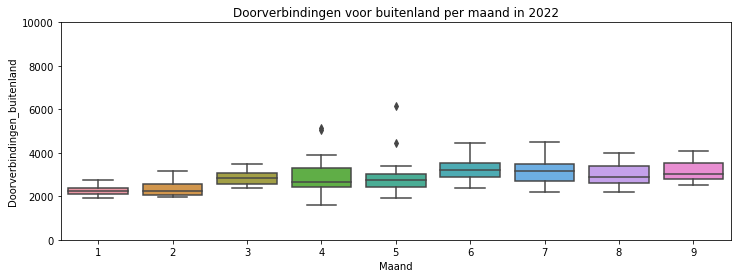

In [57]:
unieke_jaren = list(df_buitenland['Jaar'].unique())
for i, jaren in enumerate(unieke_jaren):
    fig, ax = plt.subplots()
    fig.set_size_inches((12,4))
    ax.set_ylim([0,10000])
    sns.boxplot(x = 'Maand', y = 'Doorverbindingen_buitenland', data = df_buitenland[df_buitenland['Jaar'] == jaren], ax=ax)
    plt.title('Doorverbindingen voor buitenland per maand in ' +str(unieke_jaren[i]))
    plt.show()

#### Overig

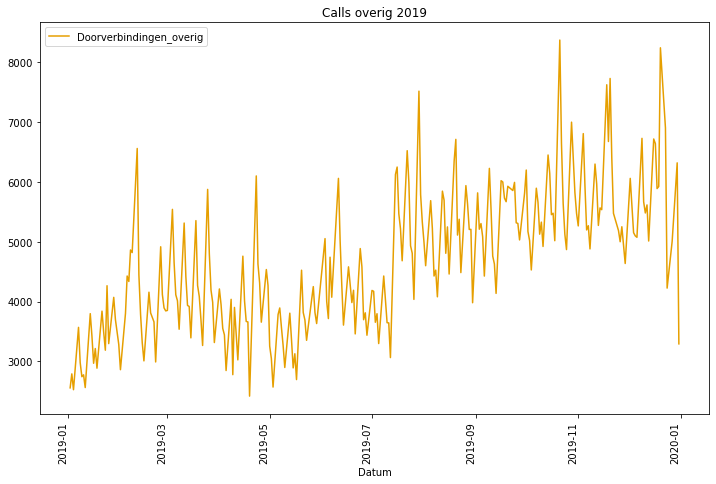

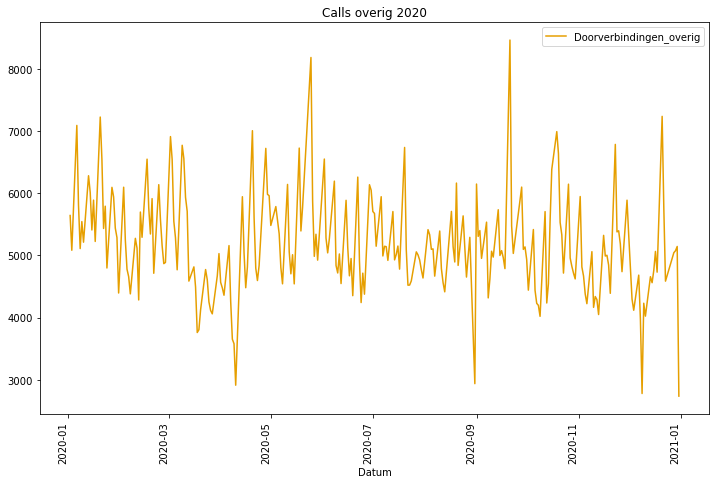

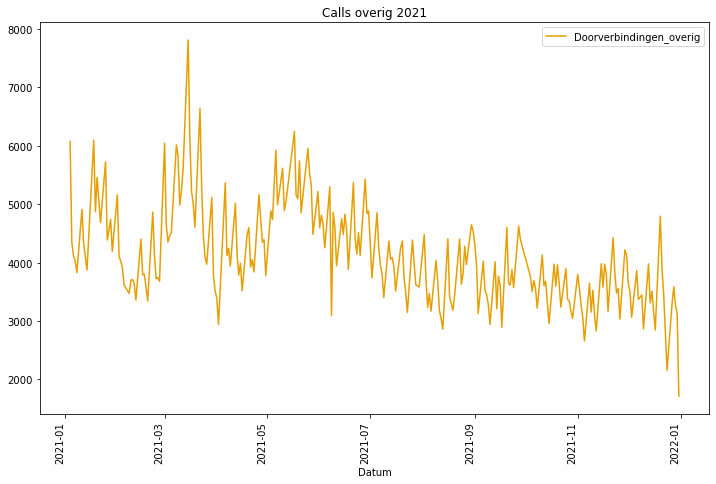

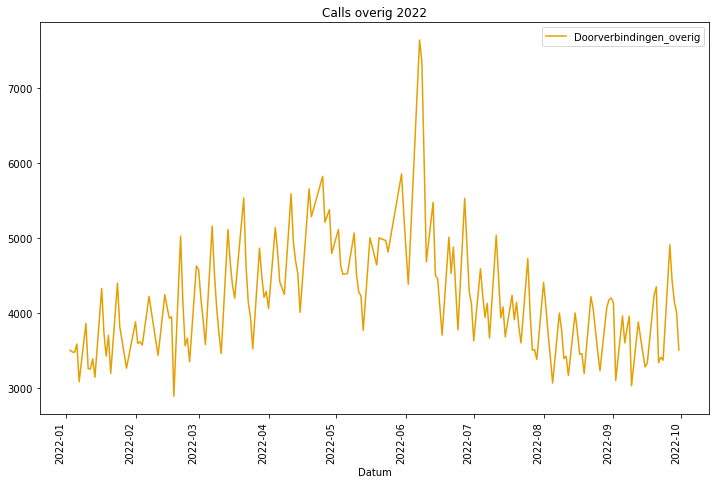

In [58]:
df_overig[(df_overig['Datum'] > pd.Timestamp(2019,1,1)) &(df_overig['Datum'] < pd.Timestamp(2020,1,1))]\
                .set_index('Datum')[['Doorverbindingen_overig']]\
                .plot(title="Calls overig 2019",figsize=(12,8))
plt.xticks(rotation = 90)

df_overig[(df_overig['Datum'] > pd.Timestamp(2020,1,1)) &(df_overig['Datum'] < pd.Timestamp(2021,1,1))]\
                .set_index('Datum')[['Doorverbindingen_overig']]\
                .plot(title="Calls overig 2020",figsize=(12,8))
plt.xticks(rotation = 90)

df_overig[(df_overig['Datum'] > pd.Timestamp(2021,1,1)) &(df_overig['Datum'] < pd.Timestamp(2022,1,1))]\
                .set_index('Datum')[['Doorverbindingen_overig']]\
                .plot(title="Calls overig 2021",figsize=(12,8))
plt.xticks(rotation = 90)

df_overig[(df_overig['Datum'] > pd.Timestamp(2022,1,1)) &(df_overig['Datum'] < pd.Timestamp(2023,1,1))]\
                .set_index('Datum')[['Doorverbindingen_overig']]\
                .plot(title="Calls overig 2022",figsize=(12,8))
plt.xticks(rotation = 90)

plt.show() 

/tmp/ipykernel_317/135637819.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_overig['SMA_calls'] = df_overig['Doorverbindingen_overig'].rolling(30).mean()


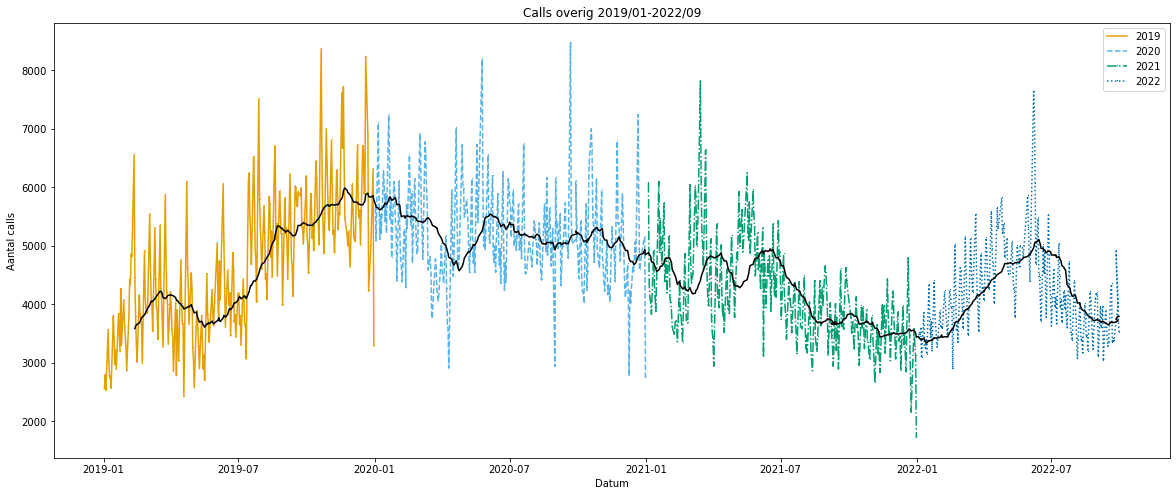

In [59]:
plt.figure(figsize = (20, 8))
plt.title('Calls overig 2019/01-2022/09')
plt.xlabel('Datum')
plt.ylabel('Aantal calls')
#plt.ylim(0,42000)

plt.plot(df_overig[(df_overig['Datum'] > pd.Timestamp(2019,1,1)) &(df_overig['Datum'] < pd.Timestamp(2020,1,1))].set_index('Datum')[['Doorverbindingen_overig']],marker=',', label= '2019')
plt.plot(df_overig[(df_overig['Datum'] > pd.Timestamp(2020,1,1)) &(df_overig['Datum'] < pd.Timestamp(2021,1,1))].set_index('Datum')[['Doorverbindingen_overig']],marker = ',', label = '2020')
plt.plot(df_overig[(df_overig['Datum'] > pd.Timestamp(2021,1,1)) &(df_overig['Datum'] < pd.Timestamp(2022,1,1))].set_index('Datum')[['Doorverbindingen_overig']],marker = ',', label = '2021')
plt.plot(df_overig[(df_overig['Datum'] > pd.Timestamp(2022,1,1)) &(df_overig['Datum'] < pd.Timestamp(2023,1,1))].set_index('Datum')[['Doorverbindingen_overig']],marker = ',', label = '2022')

df_overig['SMA_calls'] = df_overig['Doorverbindingen_overig'].rolling(30).mean()
plt.plot(df_overig['Datum'], df_overig['SMA_calls'], color = 'black')

plt.legend()

In [60]:
df_overig['Doorverbindingen_overig'].mean()

4551.357065803668

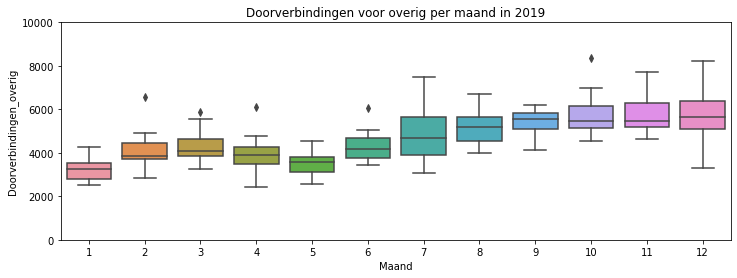

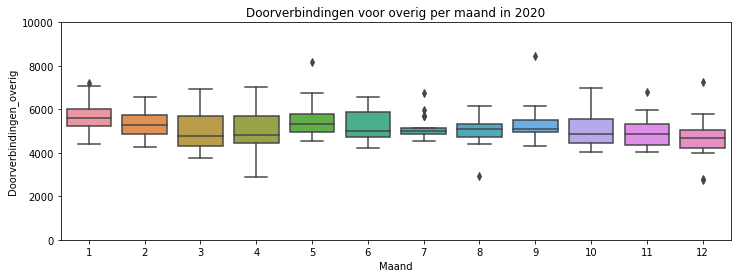

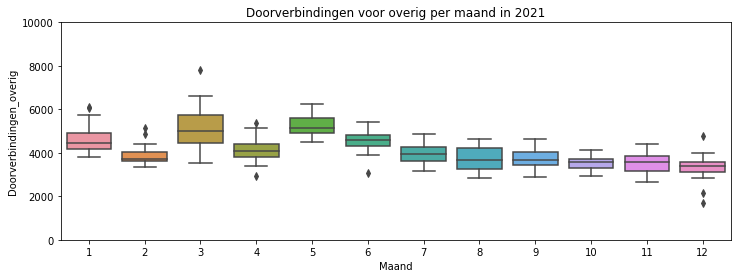

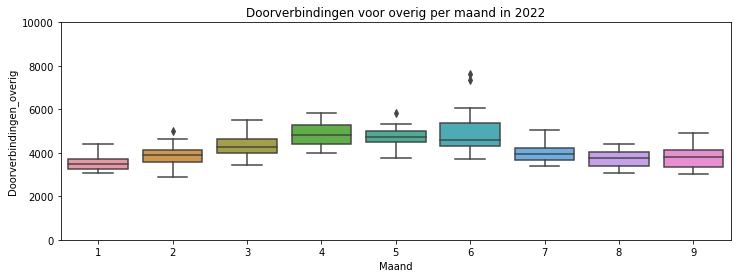

In [61]:
unieke_jaren = list(df_overig['Jaar'].unique())
for i, jaren in enumerate(unieke_jaren):
    fig, ax = plt.subplots()
    fig.set_size_inches((12,4))
    ax.set_ylim([0,10000])
    sns.boxplot(x = 'Maand', y = 'Doorverbindingen_overig', data = df_overig[df_overig['Jaar'] == jaren], ax=ax)
    plt.title('Doorverbindingen voor overig per maand in ' +str(unieke_jaren[i]))
    plt.show()

### Trend van ophangers t.o.v. wachttijd

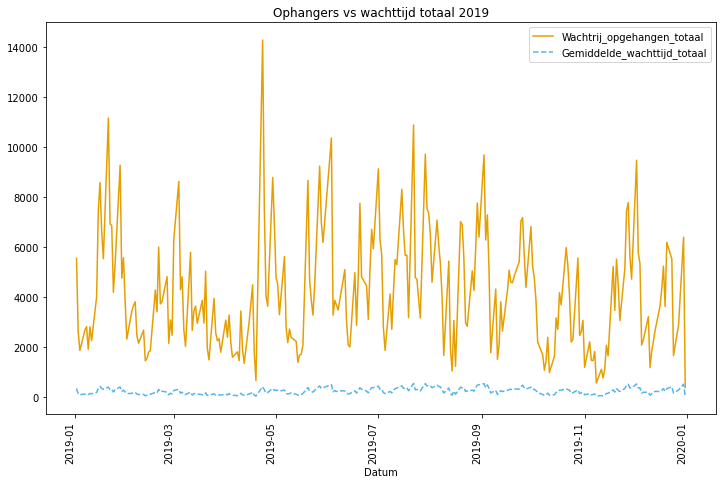

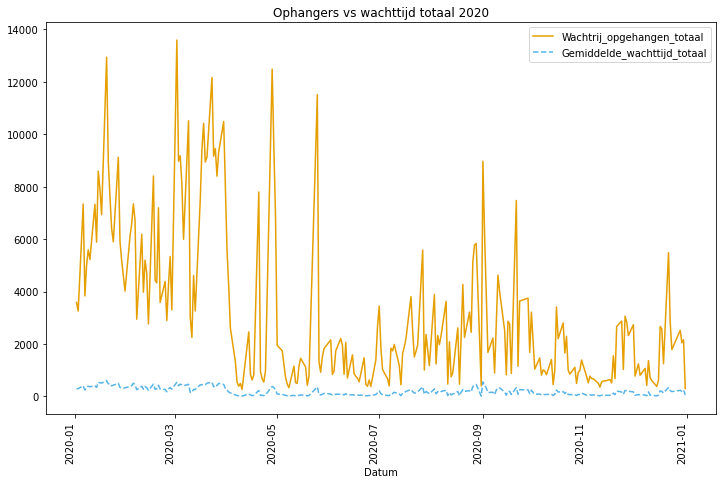

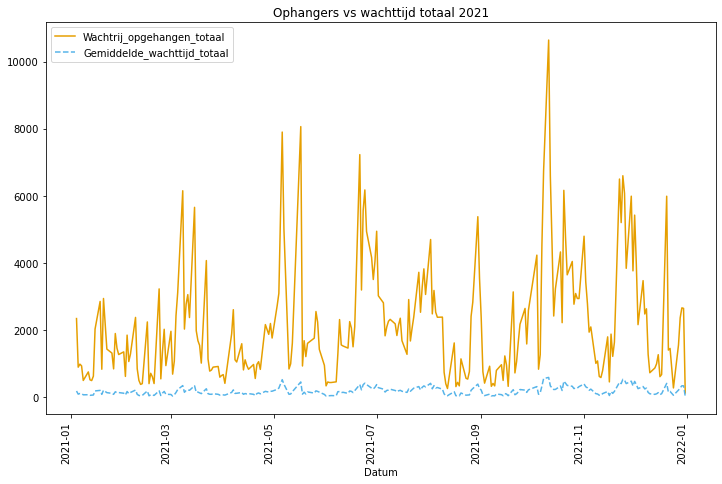

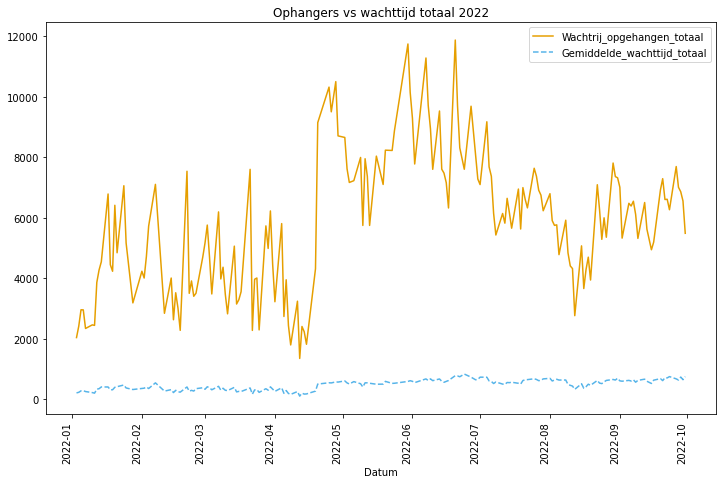

In [62]:
df_particulieren[(df_particulieren['Datum'] > pd.Timestamp(2019,1,1)) &(df_particulieren['Datum'] < pd.Timestamp(2020,1,1))]\
                .set_index('Datum')[['Wachtrij_opgehangen_totaal', 'Gemiddelde_wachttijd_totaal']]\
                .plot(title="Ophangers vs wachttijd totaal 2019",figsize=(12,8))
plt.xticks(rotation = 90)

df_particulieren[(df_particulieren['Datum'] > pd.Timestamp(2020,1,1)) &(df_particulieren['Datum'] < pd.Timestamp(2021,1,1))]\
                .set_index('Datum')[['Wachtrij_opgehangen_totaal', 'Gemiddelde_wachttijd_totaal']]\
                .plot(title="Ophangers vs wachttijd totaal 2020",figsize=(12,8))
plt.xticks(rotation = 90)

df_particulieren[(df_particulieren['Datum'] > pd.Timestamp(2021,1,1)) &(df_particulieren['Datum'] < pd.Timestamp(2022,1,1))]\
                .set_index('Datum')[['Wachtrij_opgehangen_totaal', 'Gemiddelde_wachttijd_totaal']]\
                .plot(title="Ophangers vs wachttijd totaal 2021",figsize=(12,8))
plt.xticks(rotation = 90)

df_particulieren[(df_particulieren['Datum'] > pd.Timestamp(2022,1,1)) &(df_particulieren['Datum'] < pd.Timestamp(2023,1,1))]\
                .set_index('Datum')[['Wachtrij_opgehangen_totaal', 'Gemiddelde_wachttijd_totaal']]\
                .plot(title="Ophangers vs wachttijd totaal 2022",figsize=(12,8))
plt.xticks(rotation = 90)

plt.show()

### Trend van inkomende calls t.o.v. ophangers

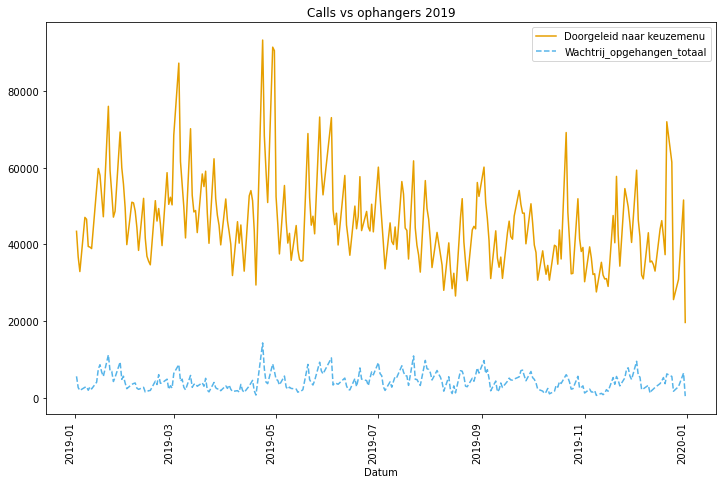

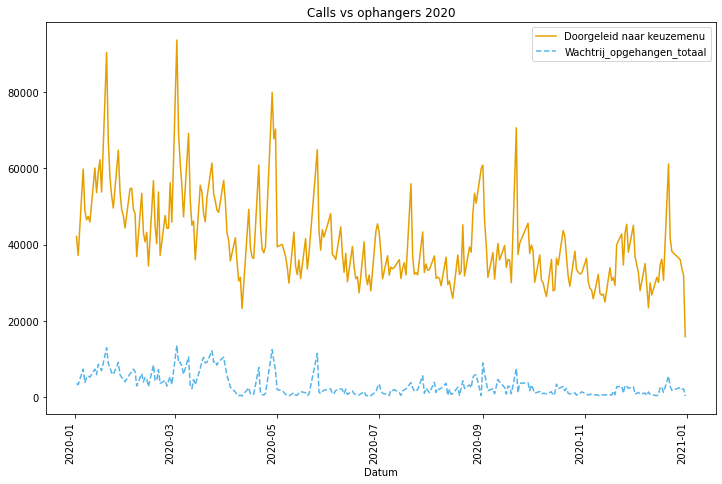

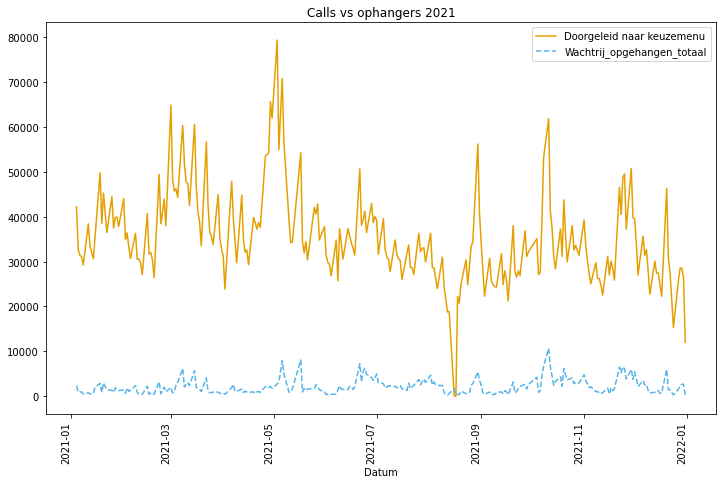

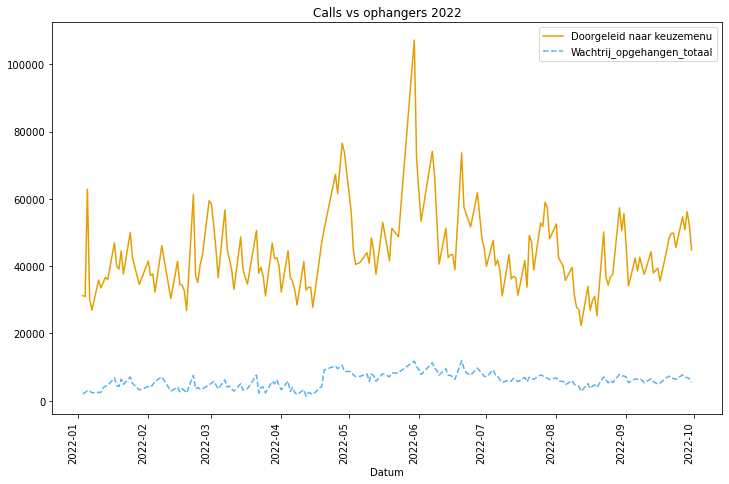

In [63]:
df_particulieren[(df_particulieren['Datum'] > pd.Timestamp(2019,1,1)) &(df_particulieren['Datum'] < pd.Timestamp(2020,1,1))]\
                .set_index('Datum')[['Doorgeleid naar keuzemenu', 'Wachtrij_opgehangen_totaal']]\
                .plot(title="Calls vs ophangers 2019",figsize=(12,8))
plt.xticks(rotation = 90)

df_particulieren[(df_particulieren['Datum'] > pd.Timestamp(2020,1,1)) &(df_particulieren['Datum'] < pd.Timestamp(2021,1,1))]\
                .set_index('Datum')[['Doorgeleid naar keuzemenu', 'Wachtrij_opgehangen_totaal']]\
                .plot(title="Calls vs ophangers 2020",figsize=(12,8))
plt.xticks(rotation = 90)

df_particulieren[(df_particulieren['Datum'] > pd.Timestamp(2021,1,1)) &(df_particulieren['Datum'] < pd.Timestamp(2022,1,1))]\
                .set_index('Datum')[['Doorgeleid naar keuzemenu', 'Wachtrij_opgehangen_totaal']]\
                .plot(title="Calls vs ophangers 2021",figsize=(12,8))
plt.xticks(rotation = 90)

df_particulieren[(df_particulieren['Datum'] > pd.Timestamp(2022,1,1)) &(df_particulieren['Datum'] < pd.Timestamp(2023,1,1))]\
                .set_index('Datum')[['Doorgeleid naar keuzemenu', 'Wachtrij_opgehangen_totaal']]\
                .plot(title="Calls vs ophangers 2022",figsize=(12,8))
plt.xticks(rotation = 90)

plt.show()

In [64]:
df_particulieren.columns

Index(['Datum', 'Maand', 'Jaar', 'DagvdWeek', 'Dag', 'WeekNr',
       'Binnengekomen bij Provider', 'Doorgeleid naar keuzemenu',
       'Door beller opgehangen in menu', 'Automatisch behandeld in menu',
       'ComplexityScore_particulieren', 'Doorverbindingen_particulieren',
       'Doorverbindingen_totaal', 'Wachtrij_particulieren', 'Wachtrij_totaal',
       'Wachtrij_opgehangen_particulieren', 'Wachtrij_opgehangen_totaal',
       'Geholpen_particulieren', 'Geholpen_totaal',
       'Gemiddelde_wachttijd_particulieren', 'Gemiddelde_wachttijd_totaal',
       'SMA_calls'],
      dtype='object')

### Vergelijking trends in geholpen bellers tussen categorieen

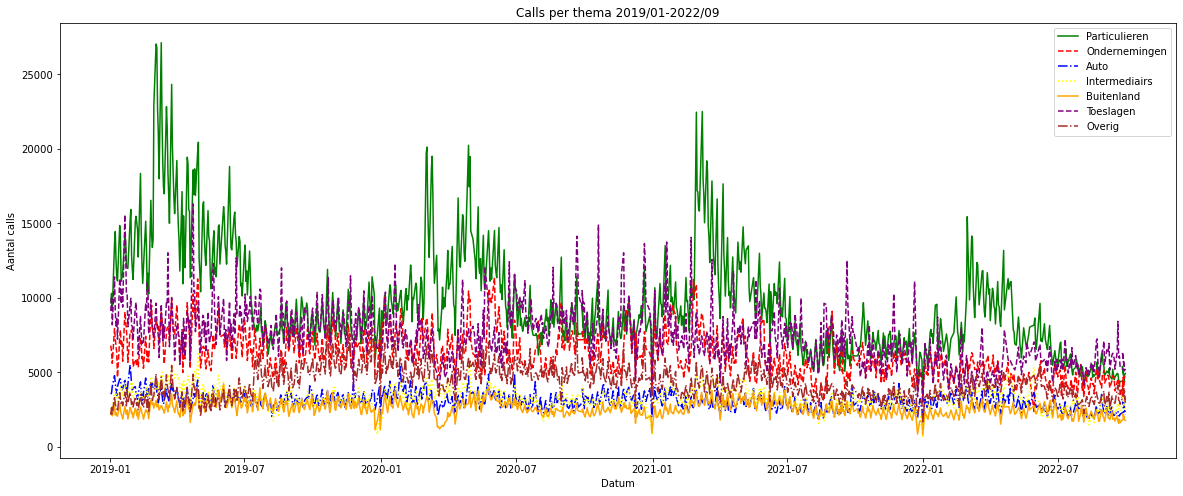

In [65]:
plt.figure(figsize = (20, 8))
plt.title('Calls per thema 2019/01-2022/09')
plt.xlabel('Datum')
plt.ylabel('Aantal calls') 

#plt.plot(df_particulieren['Datum'], df_particulieren['Geholpen_totaal'], marker=',', color='black', label= 'Particulieren')
plt.plot(df_particulieren['Datum'], df_particulieren['Geholpen_particulieren'], color='green', label= 'Particulieren')
plt.plot(df_ondernemingen['Datum'], df_ondernemingen['Geholpen_ondernemingen'], color = 'red',label = 'Ondernemingen')
plt.plot(df_auto['Datum'], df_auto['Geholpen_auto'], color='blue', label= 'Auto')
plt.plot(df_intermediairs['Datum'], df_intermediairs['Geholpen_intermediairs'], color = 'yellow',label = 'Intermediairs')
plt.plot(df_buitenland['Datum'], df_buitenland['Geholpen_buitenland'], color = 'orange',label = 'Buitenland')
plt.plot(df_toeslagen['Datum'], df_toeslagen['Geholpen_toeslagen'], color='purple', label= 'Toeslagen')
plt.plot(df_overig['Datum'], df_overig['Geholpen_overig'], color = 'brown',label = 'Overig')
plt.legend()

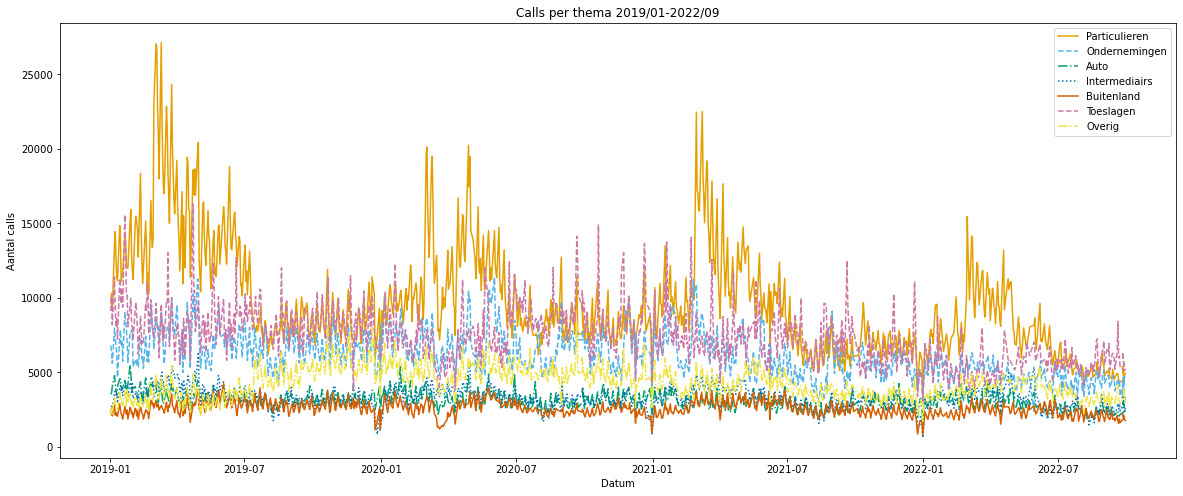

In [66]:
plt.figure(figsize = (20, 8))
plt.title('Calls per thema 2019/01-2022/09')
plt.xlabel('Datum')
plt.ylabel('Aantal calls') 

#plt.plot(df_particulieren['Datum'], df_particulieren['Geholpen_totaal'], marker=',', color='black', label= 'Particulieren')
plt.plot(df_particulieren['Datum'], df_particulieren['Geholpen_particulieren'], label= 'Particulieren')
plt.plot(df_ondernemingen['Datum'], df_ondernemingen['Geholpen_ondernemingen'], label = 'Ondernemingen')
plt.plot(df_auto['Datum'], df_auto['Geholpen_auto'], label= 'Auto')
plt.plot(df_intermediairs['Datum'], df_intermediairs['Geholpen_intermediairs'], label = 'Intermediairs')
plt.plot(df_buitenland['Datum'], df_buitenland['Geholpen_buitenland'], label = 'Buitenland')
plt.plot(df_toeslagen['Datum'], df_toeslagen['Geholpen_toeslagen'], label= 'Toeslagen')
plt.plot(df_overig['Datum'], df_overig['Geholpen_overig'], label = 'Overig')
plt.legend()

### Vergelijking trends in bellers tussen categorieen

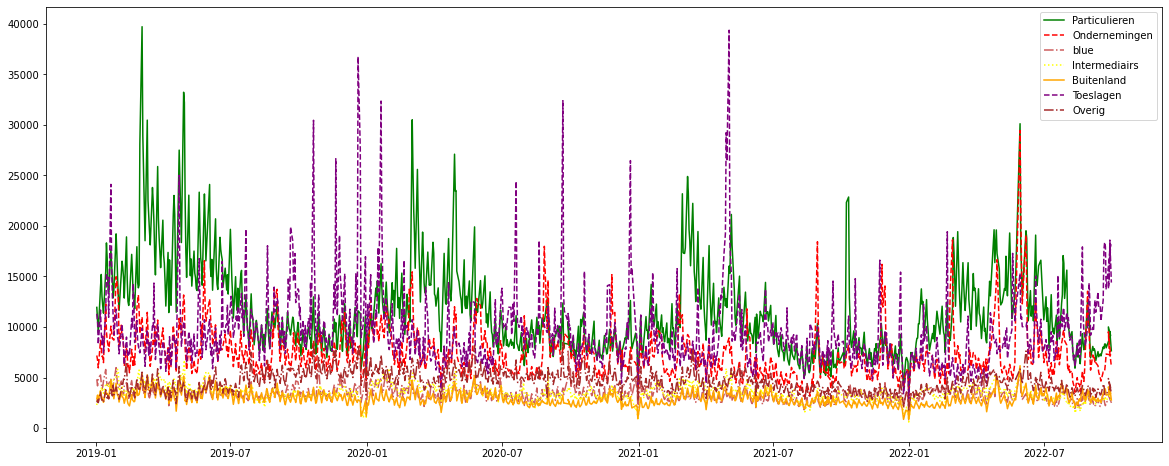

In [67]:
plt.figure(figsize = (20, 8))
plt.plot(df_particulieren['Datum'], df_particulieren['Doorverbindingen_particulieren'], color='green', label= 'Particulieren')
plt.plot(df_ondernemingen['Datum'], df_ondernemingen['Doorverbindingen_ondernemingen'], color = 'red',label = 'Ondernemingen')
plt.plot(df_auto['Datum'], df_auto['Doorverbindingen_auto'], color='indianred', label= 'blue')
plt.plot(df_intermediairs['Datum'], df_intermediairs['Doorverbindingen_intermediairs'], color = 'yellow',label = 'Intermediairs')
plt.plot(df_buitenland['Datum'], df_buitenland['Doorverbindingen_buitenland'], color = 'orange',label = 'Buitenland')
plt.plot(df_toeslagen['Datum'], df_toeslagen['Doorverbindingen_toeslagen'], color='purple', label= 'Toeslagen')
plt.plot(df_overig['Datum'], df_overig['Doorverbindingen_overig'], color = 'brown',label = 'Overig')
plt.legend()

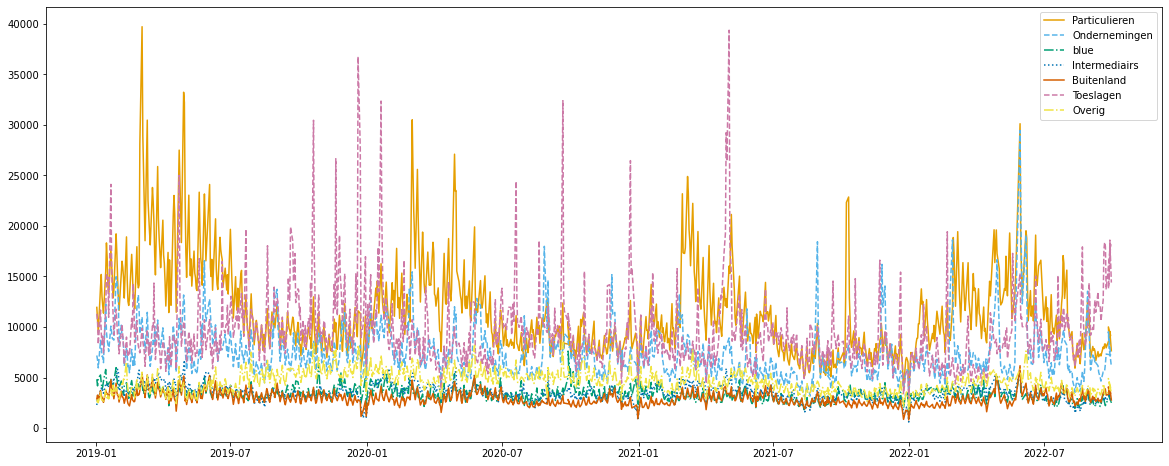

In [68]:
plt.figure(figsize = (20, 8))
plt.plot(df_particulieren['Datum'], df_particulieren['Doorverbindingen_particulieren'], label= 'Particulieren')
plt.plot(df_ondernemingen['Datum'], df_ondernemingen['Doorverbindingen_ondernemingen'], label = 'Ondernemingen')
plt.plot(df_auto['Datum'], df_auto['Doorverbindingen_auto'], label= 'blue')
plt.plot(df_intermediairs['Datum'], df_intermediairs['Doorverbindingen_intermediairs'], label = 'Intermediairs')
plt.plot(df_buitenland['Datum'], df_buitenland['Doorverbindingen_buitenland'], label = 'Buitenland')
plt.plot(df_toeslagen['Datum'], df_toeslagen['Doorverbindingen_toeslagen'], label= 'Toeslagen')
plt.plot(df_overig['Datum'], df_overig['Doorverbindingen_overig'], label = 'Overig')
plt.legend()

### Moving average of calls

In [69]:
df_particulieren['SMA_calls'] = df_particulieren['Doorverbindingen_particulieren'].rolling(30).mean()#.dropna()

/tmp/ipykernel_317/2990938349.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_particulieren['SMA_calls'] = df_particulieren['Doorverbindingen_particulieren'].rolling(30).mean()#.dropna()


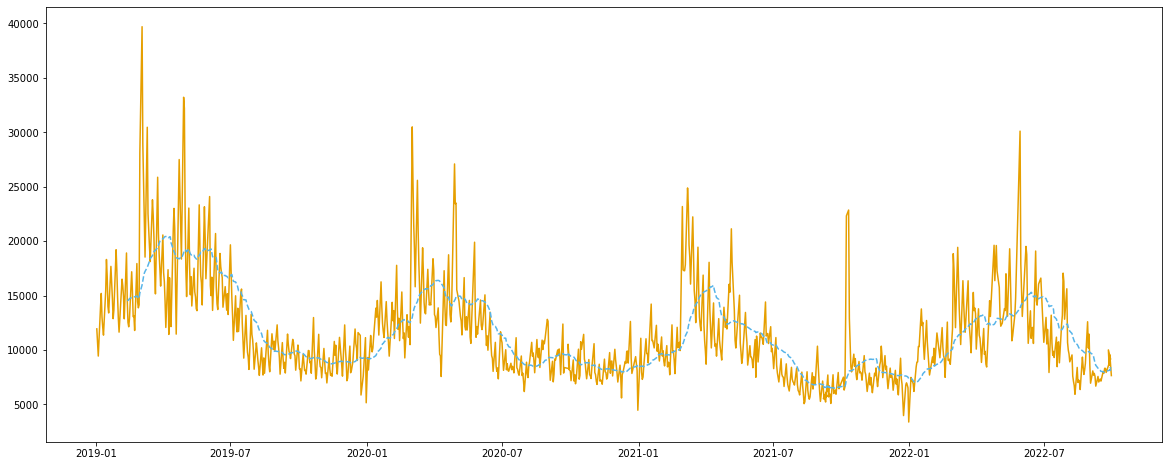

In [70]:
plt.figure(figsize = (20,8))
plt.plot(df_particulieren['Datum'], df_particulieren['Doorverbindingen_particulieren'])
plt.plot(df_particulieren['Datum'], df_particulieren['SMA_calls'])
# added moving averages to call plots 

### Invloed van wetswijzigingen op doorverbindingen

#### Particulieren

Text(0.5, 1.0, 'Analyse invloed herstel box 3')

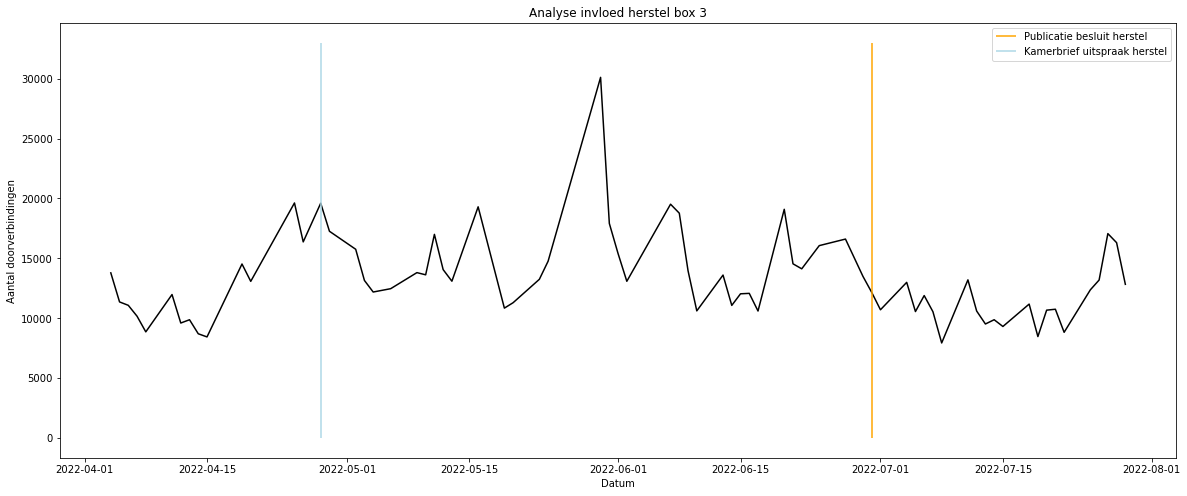

In [71]:
# 30 juni 2022 publicatie herstel box 3
plt.figure(figsize = (20,8))
plt.plot(df_particulieren[(df_particulieren['Datum'] > pd.Timestamp(2022,4,1)) &(df_particulieren['Datum'] < pd.Timestamp(2022,8,1))].set_index('Datum')[['Doorverbindingen_particulieren']], color = 'black')
plt.vlines(pd.Timestamp(2022,6,30), 0, 33000,color='orange', label = 'Publicatie besluit herstel')
plt.vlines(pd.Timestamp(2022,4,28), 0, 33000,color='lightblue', label = 'Kamerbrief uitspraak herstel')
plt.legend()
plt.xlabel('Datum')
plt.ylabel('Aantal doorverbindingen')
plt.title('Analyse invloed herstel box 3')

#### Ondernemingen

Text(0.5, 1.0, 'Analyse invloed Besluit TOZO')

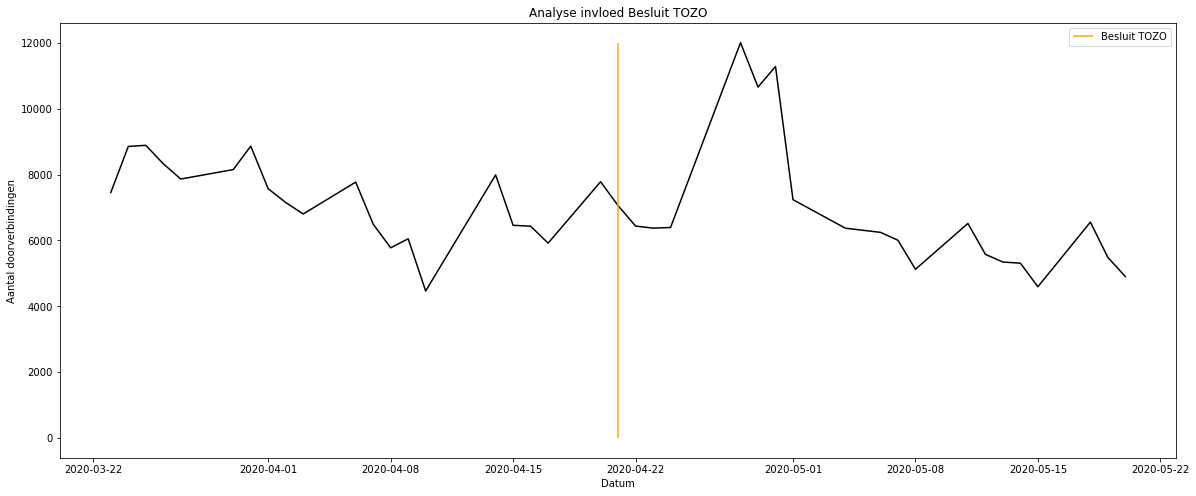

In [72]:
# Corona: TOZO - besluit van 17 april 2020; invoering met terugwerkende kracht per 1 maart 2020
plt.figure(figsize = (20,8))
plt.plot(df_ondernemingen[(df_ondernemingen['Datum'] > pd.Timestamp(2020,3,21)) &(df_ondernemingen['Datum'] < pd.Timestamp(2020,5,21))].set_index('Datum')[['Doorverbindingen_ondernemingen']], color='black')
plt.vlines(pd.Timestamp(2020,4,21), 0, 12000,color='orange', label = 'Besluit TOZO')
plt.legend()
plt.xlabel('Datum')
plt.ylabel('Aantal doorverbindingen')
plt.title('Analyse invloed Besluit TOZO')

#### Intermediairs

Text(0.5, 1.0, 'Analyse invloeden aankondigingen van wetswijzigingen en besluiten')

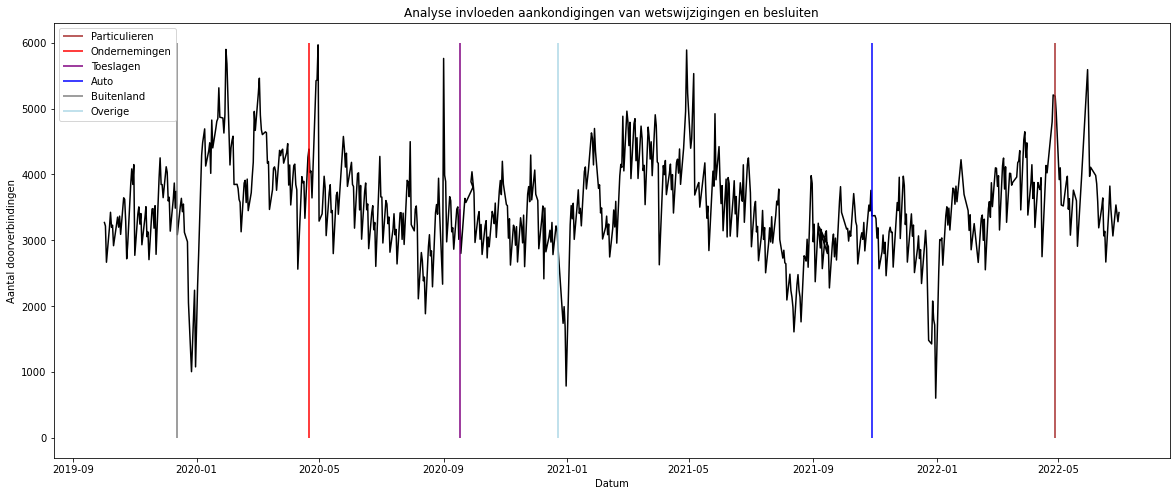

In [73]:
plt.figure(figsize = (20,8))
plt.plot(df_intermediairs[(df_ondernemingen['Datum'] > pd.Timestamp(2019,10,1)) &(df_intermediairs['Datum'] < pd.Timestamp(2022,7,1))].set_index('Datum')[['Doorverbindingen_intermediairs']], color = 'black')
# voor elke aankondiging van een wetswijziging/besluit een lijn!
plt.vlines(pd.Timestamp(2022,4,28), 0, 6000,color='brown', label= 'Particulieren')
plt.vlines(pd.Timestamp(2020,4,21), 0, 6000,color='red', label = 'Ondernemingen')
plt.vlines(pd.Timestamp(2020,9,17), 0, 6000,color='purple', label = 'Toeslagen')
plt.vlines(pd.Timestamp(2021,10,29), 0, 6000,color='blue', label = 'Auto')
plt.vlines(pd.Timestamp(2019,12,13), 0, 6000,color='grey', label = 'Buitenland')
plt.vlines(pd.Timestamp(2020,12,23), 0, 6000,color='lightblue', label = 'Overige')
plt.legend()
plt.xlabel('Datum')
plt.ylabel('Aantal doorverbindingen')
plt.title('Analyse invloeden aankondigingen van wetswijzigingen en besluiten')

#### Toeslagen

Text(0.5, 1.0, 'Analyse invloed Wet verbetering uitvoerbaarheid toeslagen')

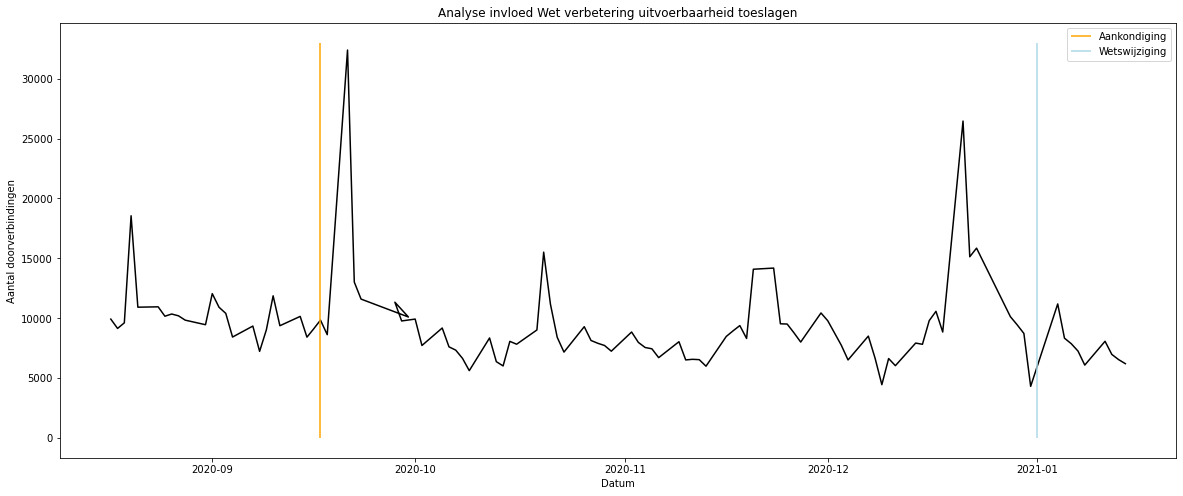

In [74]:
# publicatie 17-09-2020
plt.figure(figsize = (20,8))
plt.plot(df_toeslagen[(df_toeslagen['Datum'] > pd.Timestamp(2020,8,15)) &(df_toeslagen['Datum'] < pd.Timestamp(2021,1,15))].set_index('Datum')[['Doorverbindingen_toeslagen']], color = 'black')
plt.vlines(pd.Timestamp(2020,9,17), 0, 33000,color='orange', label = 'Aankondiging')
plt.vlines(pd.Timestamp(2021,1,1), 0, 33000,color='lightblue', label = 'Wetswijziging')
plt.legend()
plt.xlabel('Datum')
plt.ylabel('Aantal doorverbindingen')
plt.title('Analyse invloed Wet verbetering uitvoerbaarheid toeslagen')

#### Auto

Text(0.5, 1.0, 'Analyse invloed aanpassing CO2-schijfgrenzen, schrijftarieven personenauto en cap emissievrije personenauto')

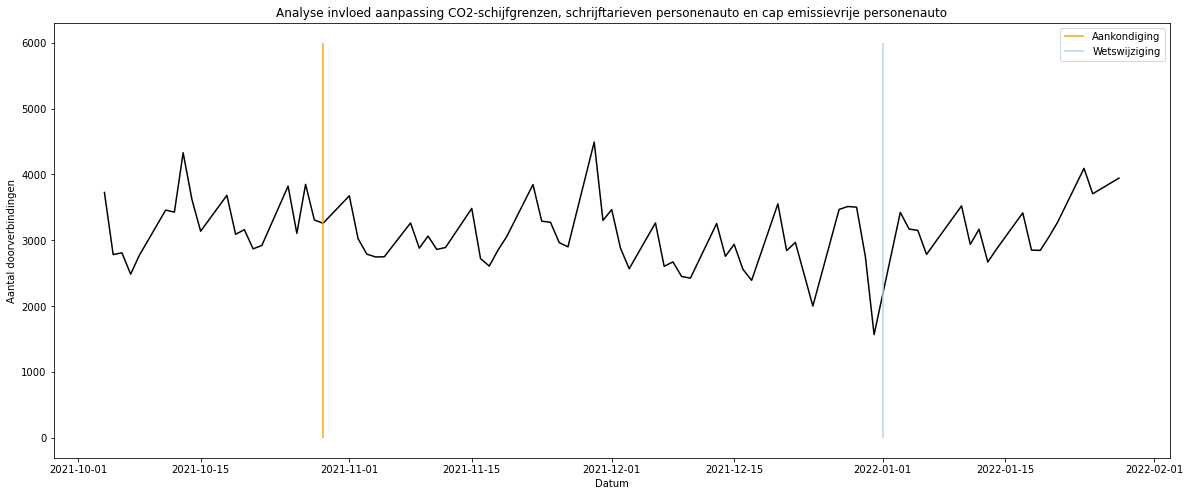

In [75]:
# 16. Aanpassen CO2-schijfgrenzen en de schijftarieven voor personenauto’s en de CO2-grens en tarief voor de dieseltoeslag voor personenauto’s
plt.figure(figsize = (20,8))
plt.plot(df_auto[(df_auto['Datum'] > pd.Timestamp(2021,10,1)) &(df_auto['Datum'] < pd.Timestamp(2022,2,1))].set_index('Datum')[['Doorverbindingen_auto']], color = 'black')
plt.vlines(pd.Timestamp(2021,10,29), 0, 6000,color='orange', label = 'Aankondiging')
plt.vlines(pd.Timestamp(2022,1,1), 0, 6000,color='lightblue', label = 'Wetswijziging')
plt.legend()
plt.xlabel('Datum')
plt.ylabel('Aantal doorverbindingen')
plt.title('Analyse invloed aanpassing CO2-schijfgrenzen, schrijftarieven personenauto en cap emissievrije personenauto')

#### Buitenland

Text(0.5, 1.0, 'Analyse invloed Besluit Pro-rata-aftrek persoonlijke aftrekposten buitenlands belastingplichtige')

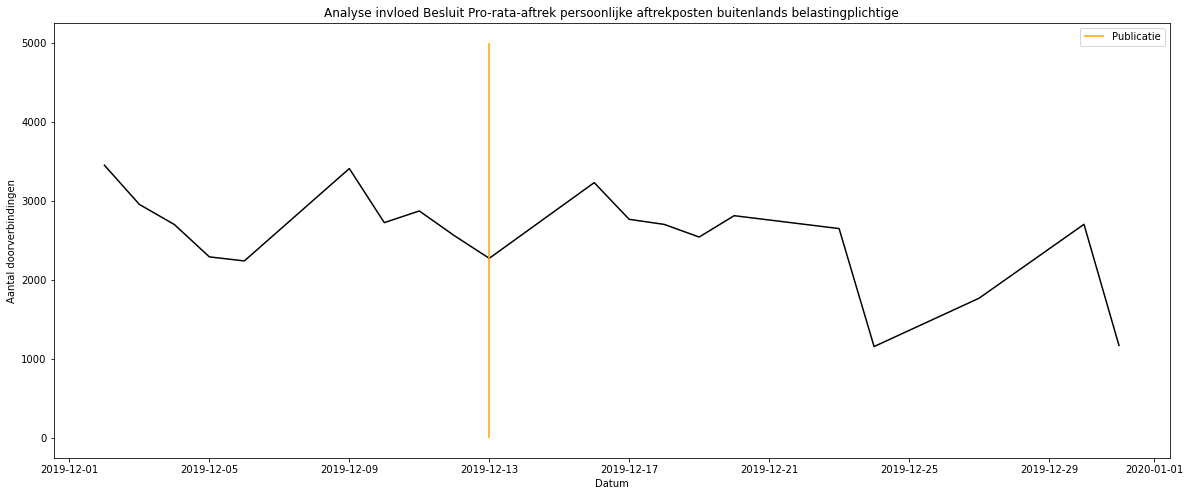

In [76]:
# 13-12-2019
plt.figure(figsize = (20,8))
plt.plot(df_buitenland[(df_buitenland['Datum'] > pd.Timestamp(2019,12,1)) &(df_buitenland['Datum'] < pd.Timestamp(2020,1,1))].set_index('Datum')[['Doorverbindingen_buitenland']], color = 'black')
plt.vlines(pd.Timestamp(2019,12,13), 0, 5000,color='orange', label = 'Publicatie')
plt.legend()
plt.xlabel('Datum')
plt.ylabel('Aantal doorverbindingen')
plt.title('Analyse invloed Besluit Pro-rata-aftrek persoonlijke aftrekposten buitenlands belastingplichtige')

#### Overige

Text(0.5, 1.0, 'Analyse invloed Wet Differentiatie Overdrachtsbelasting')

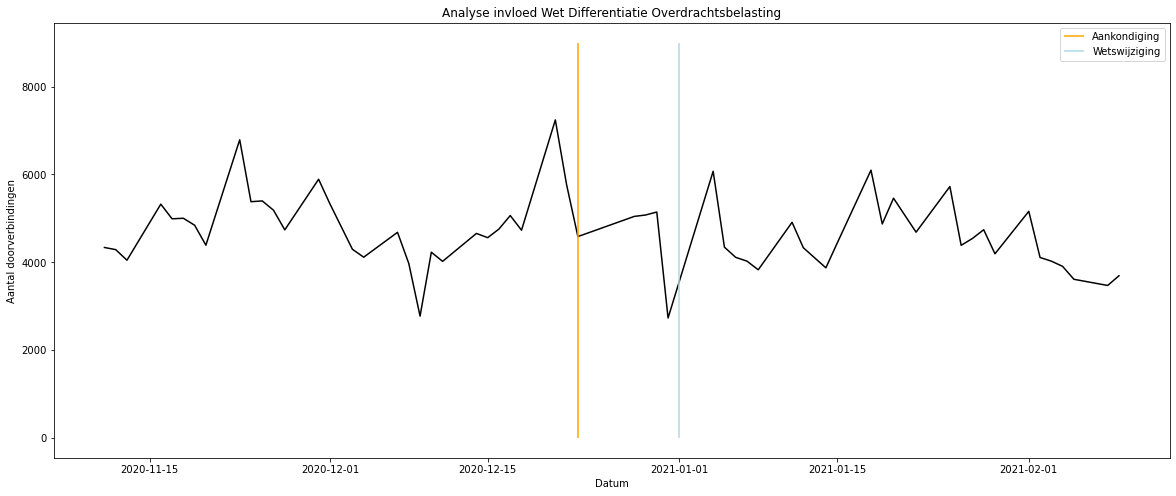

In [77]:
#  publicatie wet differentiatie overdrachtsbelasting 
plt.figure(figsize = (20,8))
plt.plot(df_overig[(df_overig['Datum'] > pd.Timestamp(2020,11,10)) &(df_overig['Datum'] < pd.Timestamp(2021,2,10))].set_index('Datum')[['Doorverbindingen_overig']], color = 'black')
plt.vlines(pd.Timestamp(2020,12,23), 0, 9000,color='orange', label = 'Aankondiging')
plt.vlines(pd.Timestamp(2021,1,1), 0, 9000,color='lightblue', label = 'Wetswijziging')
plt.legend()
plt.xlabel('Datum')
plt.ylabel('Aantal doorverbindingen')
plt.title('Analyse invloed Wet Differentiatie Overdrachtsbelasting')

### Complexity score

#### Correlations in data with complexity score

In [78]:
df_totaal['ComplexityScore_ondernemingen']

0      1
1      1
2      1
3      1
4      1
      ..
922    1
923    1
924    1
925    1
926    1
Name: ComplexityScore_ondernemingen, Length: 927, dtype: int64

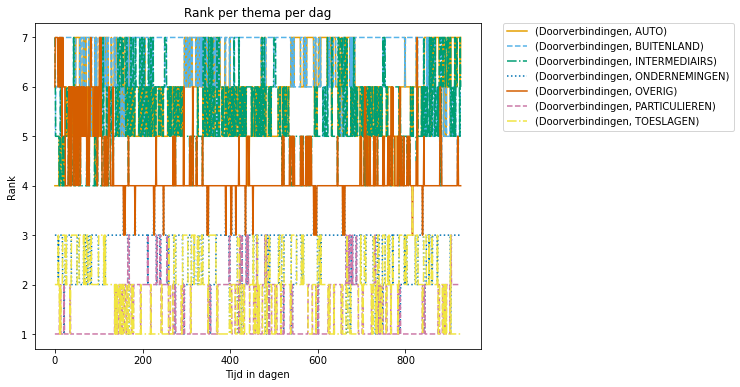

In [79]:
df_ranked_calls = df_totaal[[('Doorverbindingen', 'AUTO'),
                            ('Doorverbindingen', 'BUITENLAND'),
                            ('Doorverbindingen', 'INTERMEDIAIRS'),
                            ('Doorverbindingen', 'ONDERNEMINGEN'),
                            ('Doorverbindingen', 'OVERIG'),
                            ('Doorverbindingen', 'PARTICULIEREN'),
                            ('Doorverbindingen', 'TOESLAGEN'),
                            ]].rank(axis =1, method = 'average', ascending = False)

df_ranked_calls.plot(figsize = (8,6), title = 'Rank per thema per dag', xlabel = 'Tijd in dagen', ylabel = 'Rank')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

In [80]:
df_rank = pd.DataFrame({'Rank':df_totaal[[('Doorverbindingen', 'AUTO'),
              ('Doorverbindingen', 'BUITENLAND'),
           ('Doorverbindingen', 'INTERMEDIAIRS'),
           ('Doorverbindingen', 'ONDERNEMINGEN'),
                  ('Doorverbindingen', 'OVERIG'),
           ('Doorverbindingen', 'PARTICULIEREN'),
               ('Doorverbindingen', 'TOESLAGEN'),
          ]].rank(axis =1, method = 'average', ascending = False).mean().sort_values(), 'Absolute rank': [1,2,3,4,5,6,7], 'Score':[2,6,1,4,5,7,3]})